## Seleccion de caracteristicas

Características seleccionadas por correlación (|r| > 0.3):
pb_contenido         0.382141
ag_cabeza            0.342902
ag_contenido         0.330906
cu_concentrado_pb   -0.375818
pb_colas_fe         -0.412045
pb_concentrado_fe   -0.550546
pb_concentrado_zn   -0.560441
pb_colas_pb         -0.653392
Name: pb_recuperacion, dtype: float64


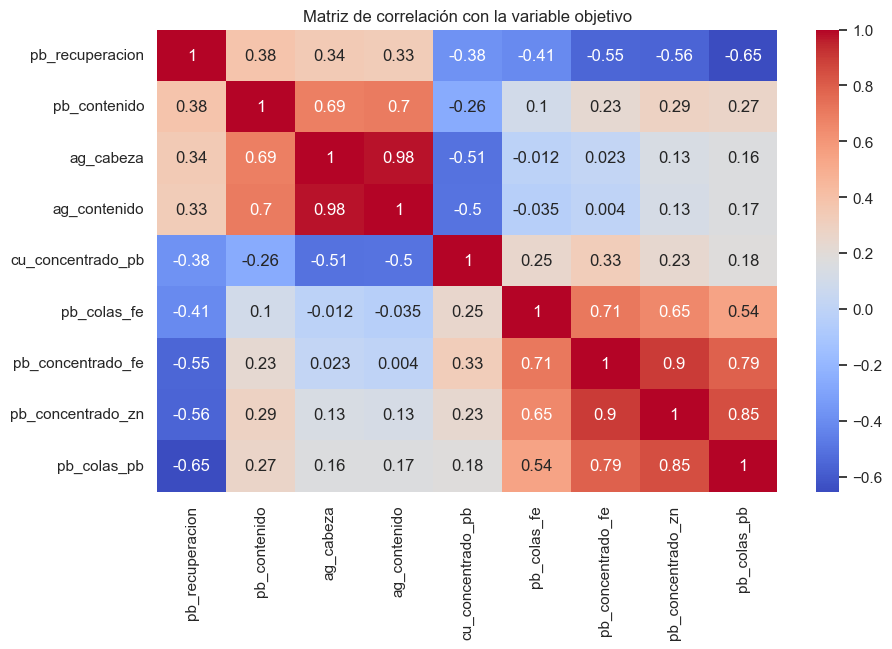

NameError: name 'target' is not defined

In [108]:
# --- Ejecución del Análisis ---
filename = 'data_variables_objetivo.csv'
columna_a_analizar = 'pb_recuperacion'

df_features = pd.read_csv(filename, index_col=0, parse_dates=False)
df_corr = df_features.select_dtypes(include=['number'])

#--- Calcular correlación ---
correlation_matrix = df_corr.corr()

# --- Ver correlación con la variable objetivo ---
cor_target = correlation_matrix[columna_a_analizar].drop(columna_a_analizar).sort_values(ascending=False)

# --- Seleccionar las variables más correlacionadas (por ejemplo, abs(corr) > 0.3) ---
threshold = 0.3
selected_features = cor_target[abs(cor_target) > threshold].index.tolist()

# --- Mostrar resultados ---
print("Características seleccionadas por correlación (|r| > 0.3):")
print(cor_target[abs(cor_target) > threshold])

# --- (Opcional) Visualización heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr[[columna_a_analizar] + selected_features].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación con la variable objetivo')
plt.show()

# --- Crear nuevo DataFrame solo con features seleccionadas ---
df_selected = df_final_para_modelo[[target] + selected_features]

## Analisis de la Serie

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuración para mejorar la visualización de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [22]:
def cargar_y_preparar_datos(filename, columna_valor, columna_indice='fecha_turno'):
    """
    Carga los datos, procesa el índice para agrupar por fecha
    y promediar los valores de los dos turnos.
    """
    try:
        # Intenta cargar asumiendo que la primera columna es el índice
        df = pd.read_csv(filename, index_col=0, parse_dates=False)
        # Si la columna índice tiene un nombre específico y no es la primera:
        # df = pd.read_csv(filename)
        # df = df.set_index(columna_indice)

        serie = df[columna_valor].copy()
    except FileNotFoundError:
        print(f"Error: El archivo '{filename}' no fue encontrado.")
        return None
    except KeyError:
        print(f"Error: La columna '{columna_valor}' o '{columna_indice}' no se encontró en el archivo.")
        print(f"Columnas disponibles: {df.columns.tolist()}")
        return None

    # Extraer la parte de la fecha del índice actual
    serie.index = serie.index.astype(str) # Asegurar que el índice es string
    fecha_sin_turno = serie.index.str.split('_').str[0]

    # Agrupar por la nueva fecha y calcular la media
    serie_agrupada = serie.groupby(fecha_sin_turno).mean()

    # Convertir el nuevo índice a formato datetime
    serie_agrupada.index = pd.to_datetime(serie_agrupada.index)

    # Ordenar por fecha, por si acaso
    serie_agrupada = serie_agrupada.sort_index()

    print("Datos cargados y procesados:")
    print(serie_agrupada.head())
    print(f"\nLongitud de la serie procesada: {len(serie_agrupada)}")
    print(f"Fecha de inicio: {serie_agrupada.index.min()}")
    print(f"Fecha de fin: {serie_agrupada.index.max()}")
    return serie_agrupada

In [24]:
def analizar_serie_temporal(serie, nombre_serie, periodo_estacionalidad=7):
    """
    Realiza un análisis básico de la serie temporal:
    visualización, descomposición, prueba de estacionariedad y ACF/PACF.
    """
    if serie is None or serie.empty:
        print("La serie está vacía o no se pudo cargar. No se puede analizar.")
        return

    print(f"\n--- Análisis de la Serie Temporal: {nombre_serie} ---")

    # 1. Visualización de la serie temporal
    plt.figure(figsize=(14, 5))
    serie.plot(title=f'Serie Temporal - {nombre_serie}')
    plt.xlabel("Fecha")
    plt.ylabel(nombre_serie)
    plt.show()

    # 2. Descomposición de la serie (Tendencia, Estacionalidad, Residuos)
    # Usamos un modelo aditivo por defecto, podría ser 'multiplicative'
    # El periodo_estacionalidad depende de la naturaleza de tus datos (ej. 7 para semanal, 30 para mensual)
    # Es importante que haya al menos 2 ciclos completos de la estacionalidad para que funcione bien.
    print(f"\nDescomponiendo la serie (periodo={periodo_estacionalidad})...")
    try:
        if len(serie) >= 2 * periodo_estacionalidad:
            descomposicion = seasonal_decompose(serie, model='additive', period=periodo_estacionalidad, extrapolate_trend='freq')
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
            descomposicion.observed.plot(ax=ax1, legend=False)
            ax1.set_ylabel('Observada')
            descomposicion.trend.plot(ax=ax2, legend=False)
            ax2.set_ylabel('Tendencia')
            descomposicion.seasonal.plot(ax=ax3, legend=False)
            ax3.set_ylabel('Estacionalidad')
            descomposicion.resid.plot(ax=ax4, legend=False)
            ax4.set_ylabel('Residuo')
            plt.suptitle(f'Descomposición de {nombre_serie}', y=0.93)
            plt.tight_layout(rect=[0, 0, 1, 0.91]) # Ajustar para el supertítulo
            plt.show()
        else:
            print(f"No hay suficientes datos para una descomposición con periodo {periodo_estacionalidad} (se necesitan al menos {2*periodo_estacionalidad} puntos).")

    except Exception as e:
        print(f"Error durante la descomposición: {e}")


    # 3. Prueba de Estacionariedad (Prueba de Dickey-Fuller Aumentada - ADF)
    print("\nPrueba de Estacionariedad (ADF):")
    # Rellenar NaNs si existen (por ejemplo, si la serie original tenía huecos)
    # Usar ffill y luego bfill por si hay NaNs al principio
    serie_sin_na = serie.fillna(method='ffill').fillna(method='bfill')

    if serie_sin_na.isnull().any():
        print("La serie todavía contiene NaNs después de rellenar. Omitiendo prueba ADF.")
    else:
        resultado_adf = adfuller(serie_sin_na)
        print(f'ADF Statistic: {resultado_adf[0]}')
        print(f'p-value: {resultado_adf[1]}')
        print('Critical Values:')
        for key, value in resultado_adf[4].items():
            print(f'\t{key}: {value}')

        if resultado_adf[1] <= 0.05:
            print("Conclusión: La serie es probablemente estacionaria (se rechaza la hipótesis nula).")
        else:
            print("Conclusión: La serie es probablemente no estacionaria (no se puede rechazar la hipótesis nula).")

    # 4. Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)
    print("\nGráficos ACF y PACF:")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    plot_acf(serie_sin_na, ax=ax1, lags=min(40, len(serie_sin_na)//2 - 1)) # Mostrar hasta 40 lags o la mitad de la serie
    plot_pacf(serie_sin_na, ax=ax2, lags=min(40, len(serie_sin_na)//2 - 1), method='ywm') # method='ols' o 'ywm'
    plt.tight_layout()
    plt.show()

In [26]:
def graficar_componente_estacional_detalle(serie, nombre_serie, periodo_a_probar, num_ciclos_a_visualizar=4):
    """
    Realiza la descomposición estacional y grafica únicamente el componente estacional
    con un eje X detallado para ayudar a identificar el periodo de repetición.

    Args:
        serie (pd.Series): La serie temporal procesada (índice debe ser de tipo datetime).
        nombre_serie (str): Nombre de la serie para los títulos de la gráfica.
        periodo_a_probar (int): El periodo que se sospecha o se quiere probar para la estacionalidad
                                 (e.g., 7 para semanal, 30 para mensual).
        num_ciclos_a_visualizar (int): Cuántos ciclos del 'periodo_a_probar' se mostrarán
                                       inicialmente en el gráfico para mayor claridad.
    """
    if serie is None or serie.empty:
        print("Error: La serie de datos está vacía o no se ha proporcionado.")
        return
    
    if not isinstance(serie.index, pd.DatetimeIndex):
        print("Error: El índice de la serie debe ser de tipo pd.DatetimeIndex.")
        return

    if len(serie) < 2 * periodo_a_probar:
        print(f"Advertencia: La longitud de la serie ({len(serie)} puntos) es menor que el doble "
              f"del periodo a probar ({2 * periodo_a_probar} puntos). "
              f"La descomposición podría no ser fiable o fallar.")
        # Podrías optar por no continuar si es muy corto, o dejar que statsmodels falle.
        # Por ahora, se intentará, pero statsmodels podría lanzar un error.
        # return # Descomentar para no intentar si es muy corto

    print(f"\n--- Visualizando Componente Estacional para '{nombre_serie}' ---")
    print(f"Probando con un periodo de: {periodo_a_probar} días")

    try:
        # Realizar la descomposición estacional
        # 'extrapolate_trend='freq'' ayuda a manejar NaNs que pueden surgir en los extremos de la tendencia
        descomposicion = seasonal_decompose(serie, model='additive', period=periodo_a_probar, extrapolate_trend='freq')
        componente_estacional = descomposicion.seasonal
        
        plt.figure(figsize=(16, 7))
        
        # Para mayor claridad, graficamos solo los primeros 'num_ciclos_a_visualizar' ciclos
        # o toda la serie si es más corta que eso.
        puntos_a_visualizar = min(len(componente_estacional), periodo_a_probar * num_ciclos_a_visualizar)
        
        segmento_a_graficar = componente_estacional.iloc[:puntos_a_visualizar]
        segmento_a_graficar.plot()
        
        plt.title(f'Componente Estacional de {nombre_serie} (Periodo Probado = {periodo_a_probar} días)\n'
                  f'Mostrando los primeros {puntos_a_visualizar} días (aprox. {num_ciclos_a_visualizar} ciclos de {periodo_a_probar} días)')
        plt.xlabel("Fecha")
        plt.ylabel("Magnitud del Componente Estacional")
        plt.grid(True, which='major', linestyle='--', linewidth=0.7)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.8) # Línea en cero para referencia

        # Mejorar el formato y la frecuencia de los ticks del eje X
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d (%a)')) # Formato: Año-Mes-Día (Día de la semana abreviado)
        
        # Ajustar el localizador de ticks basado en la cantidad de puntos a visualizar
        if puntos_a_visualizar <= periodo_a_probar * 2: # Si son 1 o 2 ciclos
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Tick para cada día
            plt.xticks(rotation=70, ha='center')
        elif puntos_a_visualizar <= periodo_a_probar * 5: # Si son hasta 5 ciclos
            # Intentar poner un tick cada 'periodo_a_probar / N' días o cada X días
            # Por ejemplo, si el periodo es 7, un tick cada día o cada 2 días
            if periodo_a_probar == 7: # Semanal
                 ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            else: # Otros periodos, ticks semanales si es un rango largo
                 ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) # Tick cada Lunes
            plt.xticks(rotation=45, ha='right')
        else: # Para rangos más largos, ticks semanales o mensuales
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) # Tick cada Lunes
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout() # Ajusta el plot para que todo encaje bien
        plt.show()
        
        print(f"\n>>> ¿Cómo interpretar este gráfico para '{nombre_serie}' con periodo={periodo_a_probar}?")
        print(f"1. Busca un patrón que se repita CLARAMENTE cada {periodo_a_probar} días.")
        print(f"2. El patrón debe ser consistente a lo largo de los {num_ciclos_a_visualizar} ciclos mostrados (y si graficaras toda la serie estacional, debería mantenerse).")
        print("3. Si el patrón es irregular, o no parece repetirse cada N días, entonces el 'periodo_a_probar' actual podría no ser el correcto.")
        print("4. Prueba con diferentes valores para 'periodo_a_probar'. Comunes para datos diarios son:")
        print("   - 7 (semanal)")
        print("   - 14 (quincenal)")
        print("   - ~30 (mensual, puedes probar 28, 30 o 30.4375 si tienes datos muy largos)")
        print("   - ~91 (trimestral)")
        print("   - También puedes usar la ACF: si ves picos significativos en la ACF en lags como 7, 14, 21, etc., eso sugiere un periodo de 7.")

    except ValueError as ve:
        print(f"Error de Valor durante la descomposición o graficación: {ve}")
        print("Esto puede ocurrir si el 'periodo_a_probar' es demasiado grande para la longitud de la serie, "
              "o si la serie tiene muchos NaNs al principio/final que no se pueden manejar.")
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}")

Datos cargados y procesados:
date_index
2024-01-02    86.145873
2024-01-03    89.682565
2024-01-04    88.261568
2024-01-05    84.885887
2024-01-06    89.632562
Name: pb_recuperacion, dtype: float64

Longitud de la serie procesada: 421
Fecha de inicio: 2024-01-02 00:00:00
Fecha de fin: 2025-03-31 00:00:00

--- Análisis de la Serie Temporal: pb_recuperacion ---


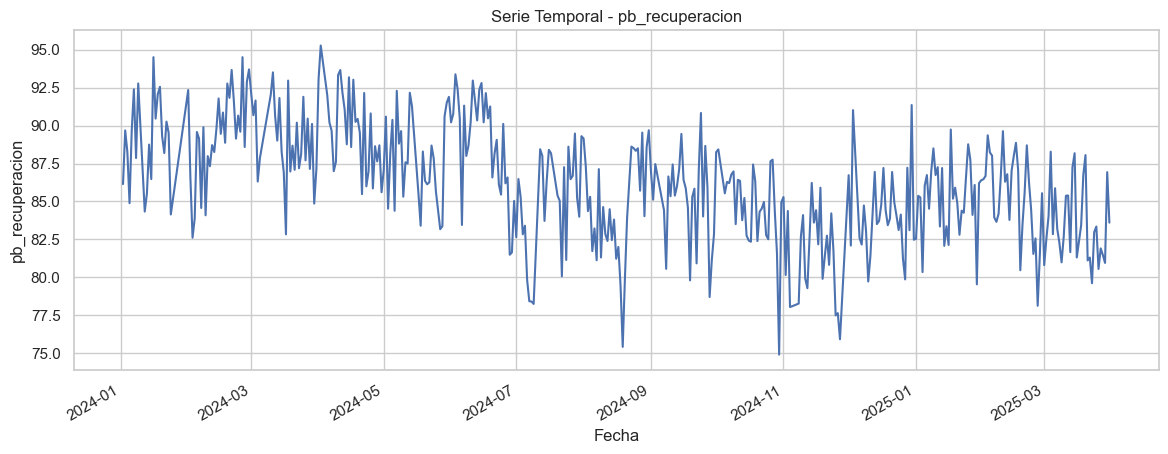


Descomponiendo la serie (periodo=7)...


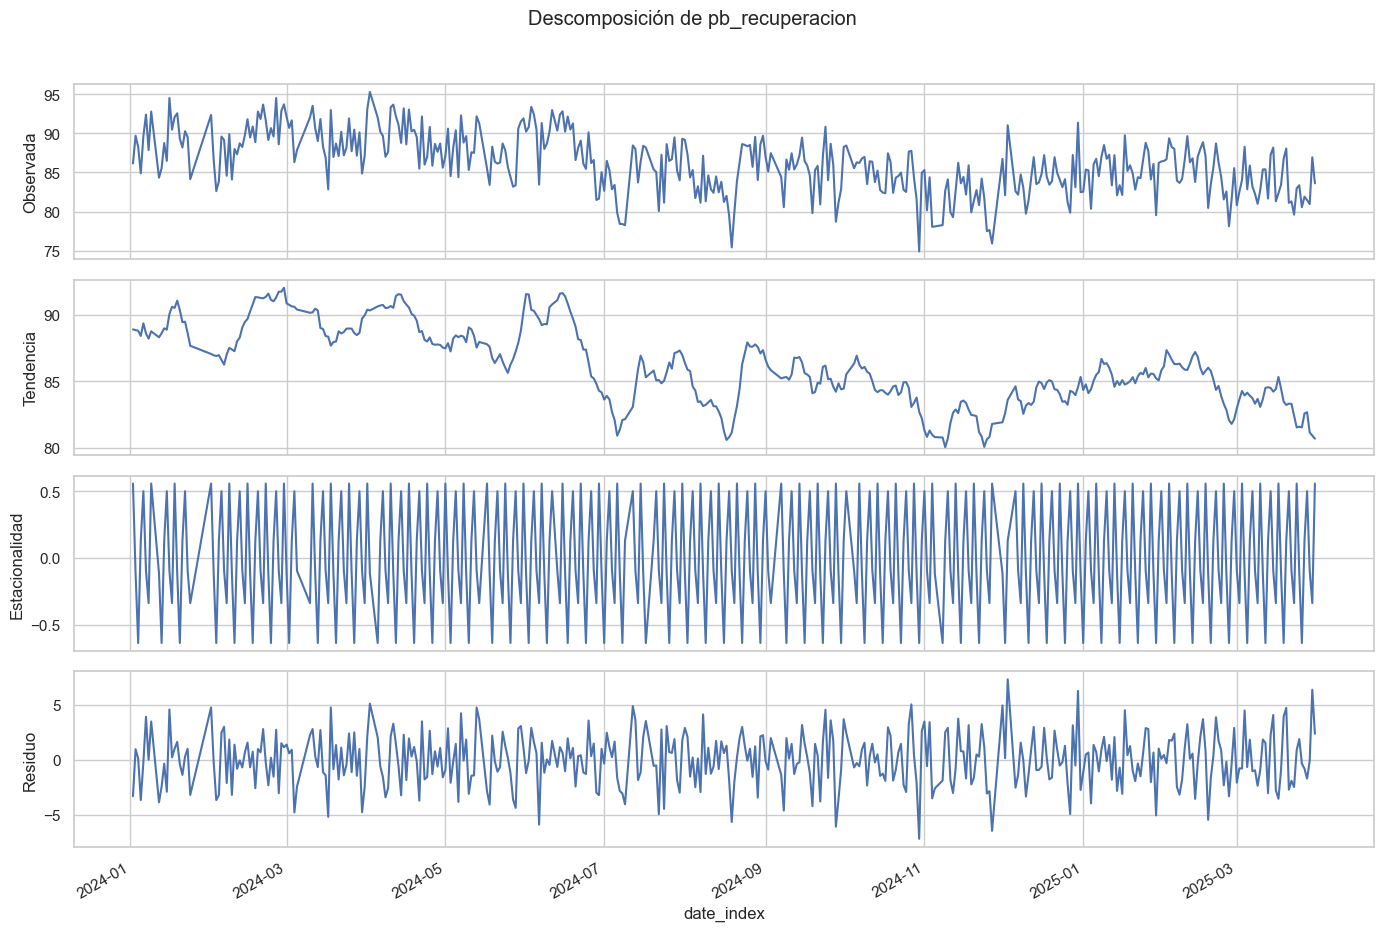


Prueba de Estacionariedad (ADF):
ADF Statistic: -3.1891039162029626
p-value: 0.02062411412240592
Critical Values:
	1%: -3.4462444670071046
	5%: -2.8685466682709975
	10%: -2.5705023309762187
Conclusión: La serie es probablemente estacionaria (se rechaza la hipótesis nula).

Gráficos ACF y PACF:


C:\Users\Cris2\AppData\Local\Temp\ipykernel_8996\402606724.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_sin_na = serie.fillna(method='ffill').fillna(method='bfill')


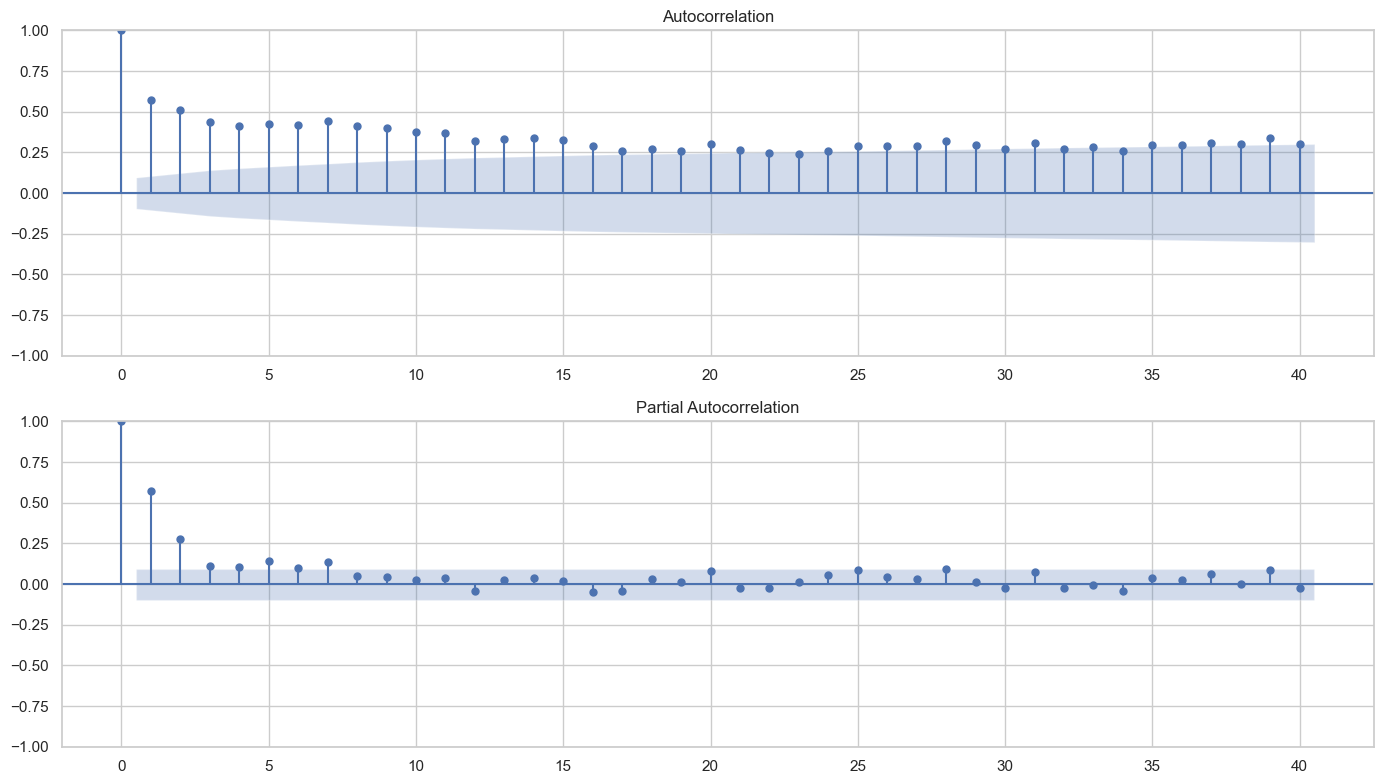


--- Visualizando Componente Estacional para 'pb_recuperacion' ---
Probando con un periodo de: 7 días
Ocurrió un error inesperado: name 'mdates' is not defined

--- Visualizando Componente Estacional para 'pb_recuperacion' ---
Probando con un periodo de: 30 días
Ocurrió un error inesperado: name 'mdates' is not defined

--- Visualizando Componente Estacional para 'pb_recuperacion' ---
Probando con un periodo de: 14 días
Ocurrió un error inesperado: name 'mdates' is not defined


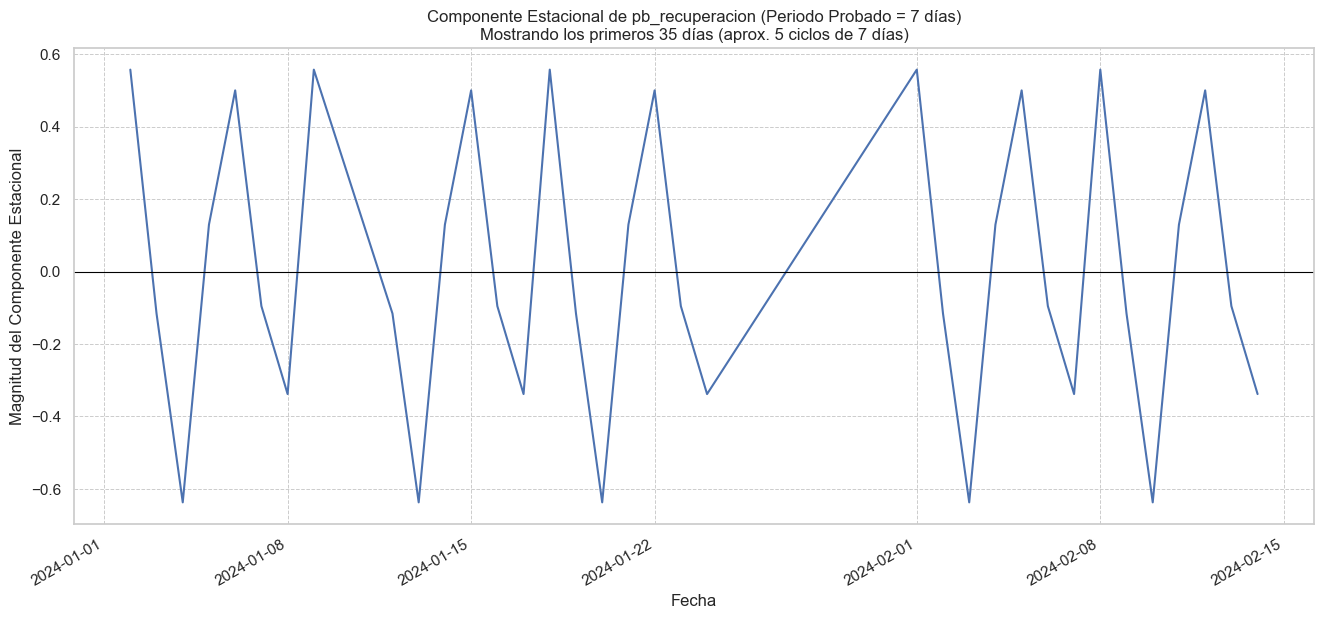

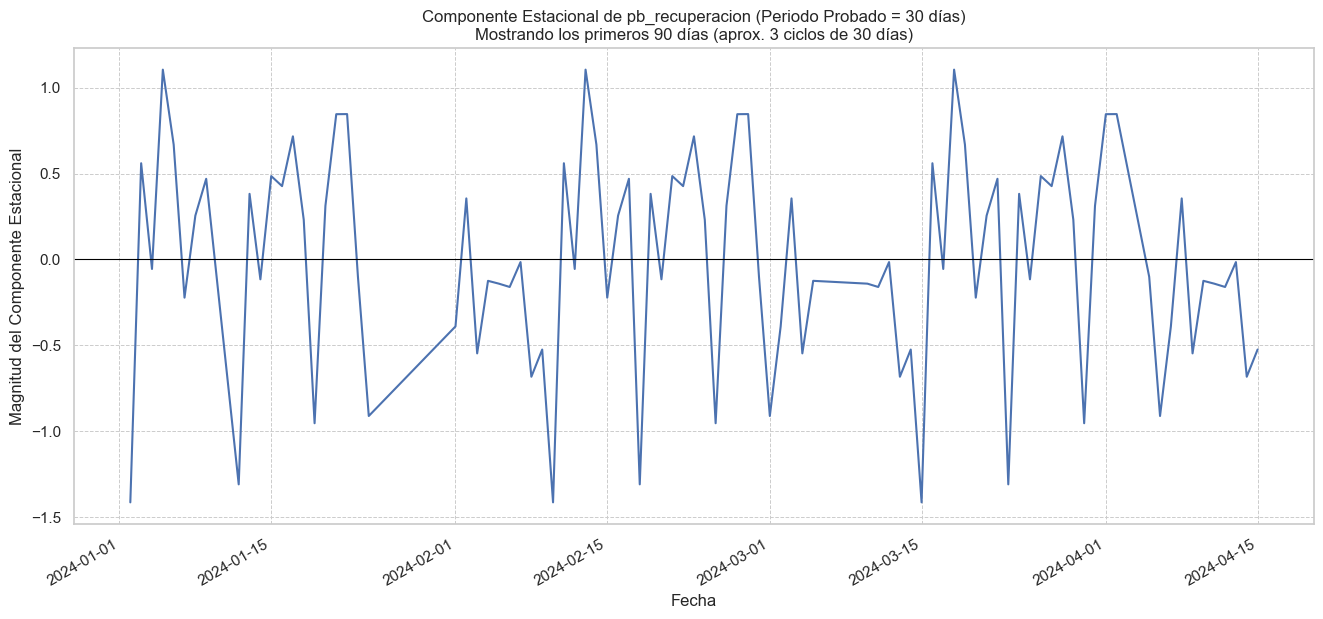

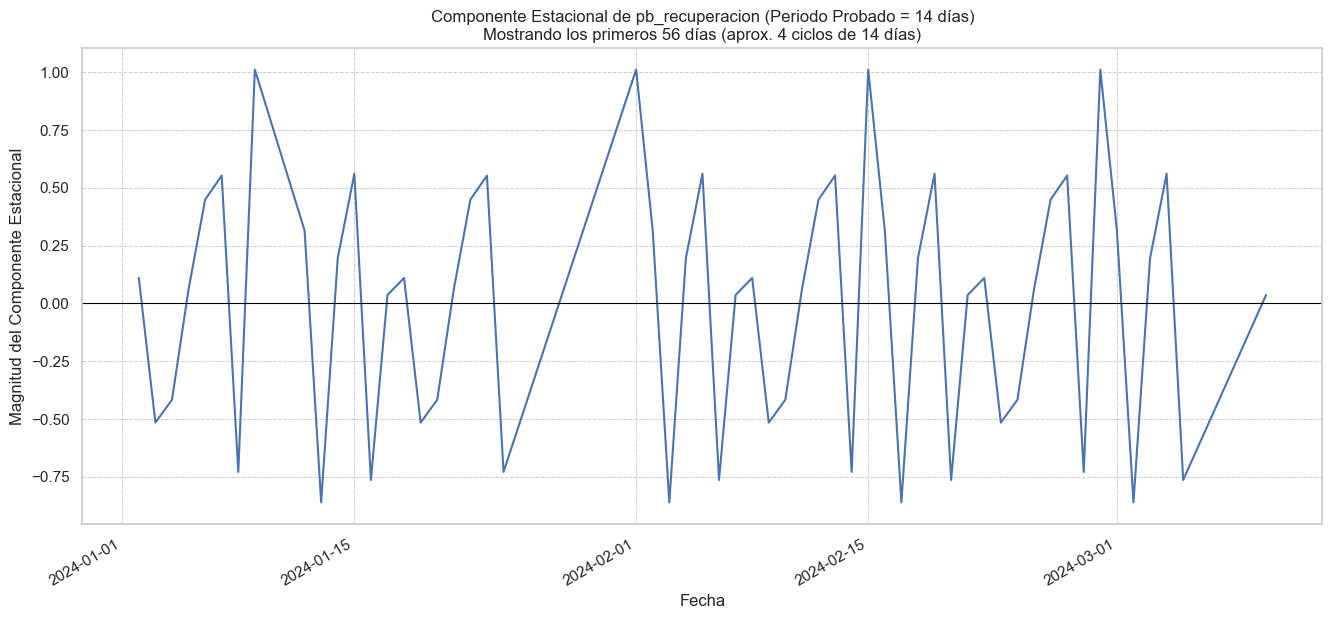

In [28]:
# --- Ejecución del Análisis ---
filename = 'data_variables_objetivo.csv'
columna_a_analizar = 'pb_recuperacion'

# Cargar y preparar los datos
serie_procesada = cargar_y_preparar_datos(filename, columna_a_analizar)

# Si los datos se cargaron correctamente, realizar el análisis
if serie_procesada is not None:
    # Puedes ajustar 'periodo_estacionalidad' según creas conveniente.
    # Por ejemplo, 7 para datos diarios con posible ciclo semanal.
    # Si tus datos después de agrupar abarcan varios años, podrías probar ~365.
    # Con 416 puntos diarios, 7 es un buen comienzo.
    analizar_serie_temporal(serie_procesada, columna_a_analizar, periodo_estacionalidad=7)

# # Una vez que 'serie_procesada' está lista:
if 'serie_procesada' in locals() and serie_procesada is not None:
#     # Prueba 1: Sospecha de estacionalidad semanal (periodo = 7)
    graficar_componente_estacional_detalle(serie_procesada, columna_a_analizar, periodo_a_probar=7, num_ciclos_a_visualizar=5)
#
#     # Prueba 2: Si la semanal no fue clara, prueba con otro periodo, ej. mensual (aprox. 30)
    graficar_componente_estacional_detalle(serie_procesada, columna_a_analizar, periodo_a_probar=30, num_ciclos_a_visualizar=3)
#
#     # Prueba 3: Quizás un ciclo de 14 días
    graficar_componente_estacional_detalle(serie_procesada, columna_a_analizar, periodo_a_probar=14, num_ciclos_a_visualizar=4)
else:
    print("Por favor, asegúrate de que 'serie_procesada' esté cargada y disponible.")


#### Conclusiones de analisis para pb_recuperacion
La tendencia de pb_recuperacion es a la baja
La serie tiene estacionalidad, tiene estacionalidad cada 7 dias
La serie a pesar de que fue limpiada con la eliminacion de outliers, si presenta algunas anomalias
La serie es estacionaria, debido a que: Prueba de Estacionariedad (ADF):
ADF Statistic: -3.1891039162029626
p-value: 0.02062411412240592
Critical Values:
	1%: -3.4462444670071046
	5%: -2.8685466682709975
	10%: -2.5705023309762187
Conclusión: La serie es probablemente estacionaria (se rechaza la hipótesis nula).

La serie esta influenciada por sus p valores anteriores
La serie tiene un decaimiento lento en la autocorrelacion 


## Ingenieria de Caracteristicas

In [32]:
def generar_caracteristicas_temporales(df_entrada, nombre_columna_objetivo,
                                       num_lags=14, # Dado que pronosticas t+14
                                       ventanas_rolling=[3, 5, 7, 14], # Ventanas para estadísticas móviles
                                       periodo_estacional_principal=7):
    """
    Genera un conjunto comprensivo de características para una serie temporal.

    Args:
        df_entrada (pd.DataFrame): DataFrame con un DatetimeIndex y la columna objetivo.
        nombre_columna_objetivo (str): El nombre de la columna de la variable objetivo.
        num_lags (int): Número de características de lag a crear.
        ventanas_rolling (list): Lista de tamaños de ventana para estadísticas móviles.
        periodo_estacional_principal (int): El periodo estacional principal (ej. 7 para semanal).

    Returns:
        pd.DataFrame: DataFrame con la columna objetivo original y las características añadidas.
    """
    if not isinstance(df_entrada.index, pd.DatetimeIndex):
        raise ValueError("El DataFrame de entrada debe tener un DatetimeIndex.")

    df = df_entrada.copy()
    serie_objetivo = df[nombre_columna_objetivo]

    # 1. Características de Lag (Valores Rezagados)
    # Estos usan valores pasados de la serie objetivo.
    for i in range(1, num_lags + 1):
        df[f'lag_{i}'] = serie_objetivo.shift(i)

    # 2. Características de Ventana Móvil (Rolling Window Features)
    # Usamos .shift(1) para asegurar que estas estadísticas se calculan usando datos
    # hasta el periodo anterior, evitando fuga de datos si se predice el valor actual.
    for ventana in ventanas_rolling:
        df[f'rolling_mean_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).mean().shift(1)
        df[f'rolling_std_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).std().shift(1)
        df[f'rolling_min_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).min().shift(1)
        df[f'rolling_max_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).max().shift(1)

    # 3. Características Basadas en Fecha/Tiempo
    df['dia_semana'] = df.index.dayofweek  # Lunes=0, Domingo=6
    df['dia_mes'] = df.index.day
    df['dia_ano'] = df.index.dayofyear
    df['mes'] = df.index.month
    df['trimestre'] = df.index.quarter
    df['semana_iso'] = df.index.isocalendar().week.astype(int) # Semana ISO del año
    df['ano'] = df.index.year

    # Crear variables dummy (one-hot encoding) para el día de la semana
    # drop_first=False para mantener todas las categorías, útil para árboles de decisión.
    # Para modelos lineales, drop_first=True puede ser preferible para evitar multicolinealidad.
    df_dow_dummies = pd.get_dummies(df['dia_semana'], prefix='dia_sem', drop_first=False)
    df = pd.concat([df, df_dow_dummies], axis=1)

    # (Opcional) Crear variables dummy para el mes
    # df_mes_dummies = pd.get_dummies(df['mes'], prefix='mes_num', drop_first=False)
    # df = pd.concat([df, df_mes_dummies], axis=1)


    # 4. Características de Fourier para la Estacionalidad Semanal (periodo_estacional_principal=7)
    # Estas ayudan a modelar patrones cíclicos de forma suave.
    if periodo_estacional_principal == 7: # Específico para semanal
        # Usamos df['dia_semana'] (0-6) para el cálculo
        for k in range(1, (periodo_estacional_principal // 2) + 1): # Para periodo 7, k será 1, 2, 3
            df[f'sin_semanal_{k}'] = np.sin(2 * np.pi * k * df['dia_semana'] / periodo_estacional_principal)
            df[f'cos_semanal_{k}'] = np.cos(2 * np.pi * k * df['dia_semana'] / periodo_estacional_principal)
    # Podrías añadir términos genéricos de Fourier si sospechas otros periodos no ligados al calendario.

    # 5. Característica de Tendencia (índice de tiempo simple)
    df['tendencia_idx'] = np.arange(len(df.index))

    # 6. Características de Momentum / Tasa de Cambio
    df['diff_1'] = serie_objetivo.diff(periods=1) # Diferencia con el día anterior
    if periodo_estacional_principal > 1:
        # Diferencia con el mismo día de la semana anterior (para periodo 7)
        df[f'diff_estacional_{periodo_estacional_principal}'] = serie_objetivo.diff(periods=periodo_estacional_principal)
    
    # Tu característica de momentum original (diferencia de 4 periodos)
    df['momentum_custom_4'] = serie_objetivo - serie_objetivo.shift(4)

    # (Opcional: Si quieres re-incluir RSI)
    # df['rsi_56'] = compute_rsi(serie_objetivo, window=56)
    
    # Nota: Muchas características creadas (lags, rolling, diffs) introducirán NaNs
    # al principio del DataFrame. Estos deben ser manejados (ej. eliminar filas o imputar)
    # antes de entrenar un modelo.
    print("Generación de características completada.")
    print(f"Forma del DataFrame original: {df_entrada.shape}, Forma del DataFrame con características: {df.shape}")
    numero_nans_estimado = max(num_lags, max(ventanas_rolling, default=0) if ventanas_rolling else 0)
    print(f"Se introducirán NaNs al inicio (aprox. {numero_nans_estimado} filas o más).")
    print("Considera usar df.head(), df.tail() y df.info() para inspeccionar el resultado.")
    
    return df

In [34]:
# Asumiendo que 'serie_procesada' es tu Serie de Pandas diaria
# y 'columna_a_analizar' es 'pb_recuperacion'
df_para_features = serie_procesada.to_frame(name=columna_a_analizar)

In [36]:
if 'df_para_features' in locals() and df_para_features is not None:
    df_con_features = generar_caracteristicas_temporales(
        df_entrada=df_para_features,
        nombre_columna_objetivo=columna_a_analizar, # ej. 'pb_recuperacion'
        num_lags=14,              # Número de lags (ej. para predecir t+14)
        ventanas_rolling=[3, 5, 7, 14], # Ventanas para medias/std móviles
        periodo_estacional_principal=7 # Estacionalidad semanal confirmada
    )

    print("\nPrimeras 20 filas del DataFrame con características (contiene NaNs al principio):")
    print(df_con_features.head(20))

    print("\nÚltimas 5 filas del DataFrame con características:")
    print(df_con_features.tail())

    print("\nInformación sobre el nuevo DataFrame:")
    df_con_features.info()

    #Antes de entrenar modelos, usualmente eliminarías las filas con NaNs
    df_final_para_modelo = df_con_features.dropna()
    print(f"\nForma después de eliminar NaNs: {df_final_para_modelo.shape}")
else:     
    print("Asegúrate de que 'serie_procesada' (convertida a DataFrame) esté disponible.")

Generación de características completada.
Forma del DataFrame original: (421, 1), Forma del DataFrame con características: (421, 55)
Se introducirán NaNs al inicio (aprox. 14 filas o más).
Considera usar df.head(), df.tail() y df.info() para inspeccionar el resultado.

Primeras 20 filas del DataFrame con características (contiene NaNs al principio):
            pb_recuperacion      lag_1      lag_2      lag_3      lag_4  \
date_index                                                                
2024-01-02        86.145873        NaN        NaN        NaN        NaN   
2024-01-03        89.682565  86.145873        NaN        NaN        NaN   
2024-01-04        88.261568  89.682565  86.145873        NaN        NaN   
2024-01-05        84.885887  88.261568  89.682565  86.145873        NaN   
2024-01-06        89.632562  84.885887  88.261568  89.682565  86.145873   
2024-01-07        92.388554  89.632562  84.885887  88.261568  89.682565   
2024-01-08        87.863062  92.388554  89.63256

## Modelos

### Modelos Lineales

#### SVM

In [74]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR # Importar SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Aunque no se usa para el split principal aquí
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- Función SMAPE ---
def smape_v2(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    epsilon = np.finfo(np.float64).eps 
    smape_values = 2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)
    return np.mean(smape_values) * 100

# --- Función Principal para el Modelo SVR con Walk-Forward ---
def entrenar_evaluar_svr_walk_forward(
    df_completo_con_features, 
    nombre_col_objetivo_original, 
    pasos_a_pronosticar_horizonte=7, 
    proporcion_entrenamiento_inicial=0.7,
    # Hiperparámetros SVR
    kernel_svr='rbf', 
    C_svr=1.0, 
    epsilon_svr=0.1,
    gamma_svr='scale'
):
    """
    Realiza validación walk-forward para SVR.
    Asume que df_completo_con_features es la salida de generar_caracteristicas_temporales.
    """
    print(f"--- Iniciando Validación Walk-Forward para SVR (t+{pasos_a_pronosticar_horizonte}) ---")
    
    # 1. Crear objetivo futuro y preparar X e y (misma lógica que para los otros modelos)
    datos = df_completo_con_features.copy()
    nombre_col_objetivo_futuro = f"objetivo_{nombre_col_objetivo_original}_t_mas_{pasos_a_pronosticar_horizonte}"
    datos[nombre_col_objetivo_futuro] = datos[nombre_col_objetivo_original].shift(-pasos_a_pronosticar_horizonte)

    columnas_a_excluir_para_X = [nombre_col_objetivo_original, nombre_col_objetivo_futuro]
    if 'dia_semana' in datos.columns and \
       (any(col.startswith('dia_sem_') for col in datos.columns) or \
        any(col.startswith('sin_semanal_') for col in datos.columns)):
        if 'dia_semana' not in columnas_a_excluir_para_X:
            columnas_a_excluir_para_X.append('dia_semana')
    # (Añadir lógica similar para 'mes' si es necesario)

    X_preliminar = datos.drop(columns=columnas_a_excluir_para_X, errors='ignore')
    y_preliminar = datos[nombre_col_objetivo_futuro]

    df_para_modelo_final = pd.concat([X_preliminar, y_preliminar], axis=1)
    df_para_modelo_final = df_para_modelo_final.astype({col: int for col in df_para_modelo_final.select_dtypes(include=['bool']).columns}, errors='ignore')
    df_para_modelo_final = df_para_modelo_final.astype('float64', errors='ignore') 
    df_para_modelo_final = df_para_modelo_final.dropna()

    if df_para_modelo_final.empty or len(df_para_modelo_final) < 20: # Umbral mínimo
        print("ERROR: df_para_modelo_final vacío o con muy pocos datos.")
        return None, None, None

    y_all = df_para_modelo_final[nombre_col_objetivo_futuro]
    X_all = df_para_modelo_final.drop(columns=[nombre_col_objetivo_futuro])
    
    if nombre_col_objetivo_futuro in X_all.columns or nombre_col_objetivo_original in X_all.columns:
        print(f"¡¡¡ERROR DE FUGA DE DATOS POTENCIAL!!! Verifique X_all.")
        exit()

    X_all_original_index = X_all.index 
    X_all_reset = X_all.reset_index(drop=True)
    y_all_reset = y_all.reset_index(drop=True)

    # 2. Escalar Características X (SVR es sensible al escalado)
    scaler = StandardScaler()
    X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_reset), columns=X_all.columns)
    print(f"Forma de X_all_scaled (features): {X_all_scaled.shape}")
    print(f"Forma de y_all_reset (objetivo futuro): {y_all_reset.shape}")

    # 3. Configuración y Bucle Walk-Forward
    tamano_entrenamiento_inicial = int(len(X_all_scaled) * proporcion_entrenamiento_inicial)
    predicciones_svr = []
    reales_svr = []
    indices_prueba_svr = []

    total_puntos_prueba = len(X_all_scaled) - tamano_entrenamiento_inicial
    if total_puntos_prueba <= 0:
        print("Error: No hay datos de prueba. Ajusta 'proporcion_entrenamiento_inicial'.")
        return None, None, None
    print(f"Tamaño total: {len(X_all_scaled)}, Entrenamiento inicial: {tamano_entrenamiento_inicial}, Prueba: {total_puntos_prueba}")

    for i in range(tamano_entrenamiento_inicial, len(X_all_scaled)): 
        X_entrenamiento_actual = X_all_scaled.iloc[:i]
        y_entrenamiento_actual = y_all_reset.iloc[:i]
        
        X_prueba_actual_step = X_all_scaled.iloc[i:i+1]
        y_real_actual_step = y_all_reset.iloc[i]

        # --- Instanciación y Entrenamiento del Modelo SVR ---
        modelo = SVR(kernel=kernel_svr, C=C_svr, epsilon=epsilon_svr, gamma=gamma_svr)
        
        try:
            modelo.fit(X_entrenamiento_actual, y_entrenamiento_actual)
            y_pred = modelo.predict(X_prueba_actual_step)[0]
        except Exception as e:
            print(f"Error entrenando o prediciendo con SVR en el paso {i}: {e}")
            y_pred = np.nan # Registrar NaN si hay error

        predicciones_svr.append(y_pred)
        reales_svr.append(y_real_actual_step)
        indices_prueba_svr.append(X_all_original_index[i])

        if (i - tamano_entrenamiento_inicial + 1) % 50 == 0:
            print(f"Validación Walk-Forward SVR: Paso {i - tamano_entrenamiento_inicial + 1}/{total_puntos_prueba} completado.")
    
    print("Validación walk-forward para SVR finalizada.")

    # 4. Evaluación
    # Filtrar NaNs en predicciones (si algún paso falló) y sus correspondientes reales
    df_resultados_temp = pd.DataFrame({'real': reales_svr, 'pred': predicciones_svr}).dropna()
    reales_np = df_resultados_temp['real'].to_numpy()
    predicciones_np = df_resultados_temp['pred'].to_numpy()
    
    metricas = {}
    if len(predicciones_np) > 0:
        metricas['wf_mae'] = mean_absolute_error(reales_np, predicciones_np)
        metricas['wf_rmse'] = np.sqrt(mean_squared_error(reales_np, predicciones_np))
        metricas['wf_mape'] = mean_absolute_percentage_error(reales_np, predicciones_np) * 100
        metricas['wf_smape'] = smape_v2(reales_np, predicciones_np) # Asegúrate de tener smape_v2 definida

        print(f'\nPronóstico para t+{pasos_a_pronosticar_horizonte} con SVR (Walk-Forward):')
        for nombre_metrica, valor in metricas.items(): print(f"{nombre_metrica}: {valor:.4f}")
    else:
        print("No hay predicciones válidas para calcular métricas para SVR.")

    df_resultados_plot = pd.DataFrame({
        'actual': reales_svr, 
        'prediccion_svr_wf': predicciones_svr
    }, index=pd.Index(indices_prueba_svr, name=X_all_original_index.name))

    return metricas, modelo, df_resultados_plot # Devuelve el último modelo ajustado y resultados

# --- BLOQUE DE EJECUCIÓN DE EJEMPLO PARA SVR ---
# (Asegúrate de que 'serie_procesada', 'generar_caracteristicas_temporales', 'smape_v2' estén definidas)
# (Y que 'columna_objetivo_original', 'num_lags_para_features', 'n_steps_ahead' también)

if 'serie_procesada' in locals() and isinstance(serie_procesada, pd.Series) and \
   'columna_objetivo_original' in locals() and isinstance(columna_objetivo_original, str) and \
   'n_steps_ahead' in locals():

    print(f"Preparando para modelar con SVR para: {columna_objetivo_original}")

    # Generar características (asumiendo que df_con_features no está ya definida con la última versión)
    df_para_features_inicial_svr = serie_procesada.to_frame(name=columna_objetivo_original)
    df_con_features_svr = generar_caracteristicas_temporales(
        df_entrada=df_para_features_inicial_svr,
        nombre_columna_objetivo=columna_objetivo_original,
        num_lags=num_lags_para_features if 'num_lags_para_features' in locals() else 14, # Usa tu valor o un default
        ventanas_rolling=[3, 5, 7, 14, 21, 28], 
        periodo_estacional_principal=7
    )
    print(f"DataFrame con features para SVR: {df_con_features_svr.shape}")

    # Configuración para SVR
    HORIZONTE_SVR = n_steps_ahead 
    PROPORCION_ENTRENAMIENTO_SVR = 0.7
    
    # Hiperparámetros para SVR (puedes ajustarlos)
    KERNEL_SVR = 'rbf' # Común para no linealidad, otros: 'linear', 'poly'
    C_SVR = 10       # Parámetro de regularización (más alto = menos regularización)
    EPSILON_SVR = 0.1 # Margen de error
    GAMMA_SVR = 'auto'  # Coeficiente del kernel para 'rbf', 'poly', 'sigmoid'

    metricas_svr, modelo_svr_final, df_resultados_svr = entrenar_evaluar_svr_walk_forward(
        df_completo_con_features=df_con_features_svr,
        nombre_col_objetivo_original=columna_objetivo_original,
        pasos_a_pronosticar_horizonte=HORIZONTE_SVR,
        proporcion_entrenamiento_inicial=PROPORCION_ENTRENAMIENTO_SVR,
        kernel_svr=KERNEL_SVR,
        C_svr=C_SVR,
        epsilon_svr=EPSILON_SVR,
        gamma_svr=GAMMA_SVR
    )

    if metricas_svr:
        print(f"\n--- Resultados Walk-Forward SVR (t+{HORIZONTE_SVR}) ---")
        # Las métricas ya se imprimieron dentro de la función.
        
        if df_resultados_svr is not None and not df_resultados_svr.empty:
            print("\nPrimeras filas del DataFrame de pronóstico SVR:")
            print(df_resultados_svr.head())
            
            if 'actual' in df_resultados_svr.columns and not df_resultados_svr['prediccion_svr_wf'].isnull().all():
                df_resultados_svr.plot(figsize=(14, 7), marker='.')
                plt.title(f"SVR (WF, t+{HORIZONTE_SVR}): Reales vs. Pronóstico para {columna_objetivo_original}")
                plt.ylabel(columna_objetivo_original)
                plt.xlabel("Fecha")
                plt.legend()
                plt.grid(True)
                plt.show()
            elif not df_resultados_svr['prediccion_svr_wf'].isnull().all():
                 df_resultados_svr['prediccion_svr_wf'].plot(figsize=(14, 7), marker='.', label='Predicción SVR')
                 plt.title(f"SVR (WF, t+{HORIZONTE_SVR}): Pronóstico para {columna_objetivo_original}")
                 plt.ylabel(columna_objetivo_original)
                 plt.xlabel("Fecha")
                 plt.legend()
                 plt.grid(True)
                 plt.show()
    elif modelo_svr_final:
        print("El modelo SVR fue ajustado, pero no se generaron resultados de pronóstico evaluables.")
else:
    print("Por favor, asegúrate de que 'serie_procesada', 'columna_objetivo_original', 'n_steps_ahead', etc., estén disponibles.")

Por favor, asegúrate de que 'serie_procesada', 'columna_objetivo_original', 'n_steps_ahead', etc., estén disponibles.


#### Ridge

Forma de X_all después de la preparación: (400, 54)
Forma de y_all después de la preparación: (400,)

Iniciando validación walk-forward para pronóstico de t+7...
Tamaño total después de preparación: 400
Tamaño de entrenamiento inicial: 280
Tamaño de prueba (orígenes de pronóstico): 120
Validación walk-forward finalizada.

Pronóstico para t+7 con validación walk-forward y normalización:
MAE: 2.4689
RMSE: 3.0734
MAPE: 0.0293
SMAPE: 2.92%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


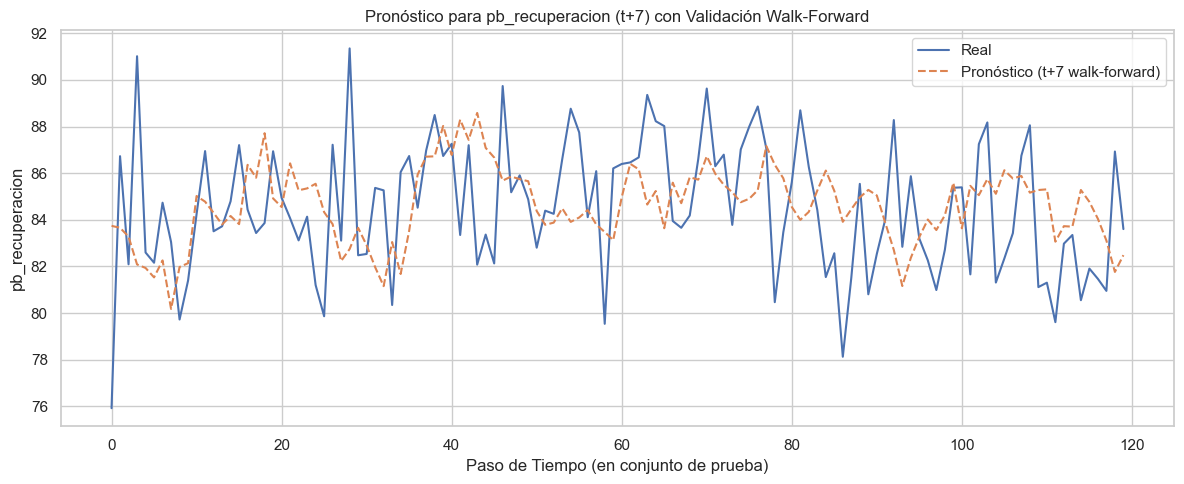

In [72]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 2. Crear la VERDADERA variable objetivo para t+N (ej. t+14)
horizonte_real = 7 # O el n_steps_ahead que desees
df_para_modelo = df_con_features.copy()
df_para_modelo['objetivo_futuro_t_mas_N'] = df_para_modelo['pb_recuperacion'].shift(-horizonte_real)

X = df_para_modelo.drop(columns=['pb_recuperacion', 'objetivo_futuro_t_mas_N'])
y = df_para_modelo['objetivo_futuro_t_mas_N']

# 4. Eliminar NaNs DESPUÉS de crear el objetivo futuro y definir X.
#    Esto eliminará las filas donde las features no se pudieron calcular (inicio)
#    Y donde el objetivo futuro no existe (final).
df_final_para_modelo = pd.concat([X, y], axis=1).dropna()

# 5. Ahora, separa de nuevo X e y para el modelo a partir de df_final_para_modelo
y_final = df_final_para_modelo[y.name] # y.name será 'objetivo_futuro_t_mas_N'
X_final = df_final_para_modelo.drop(columns=[y.name])

columna = 'pb_recuperacion' # Columna a pronosticar
n_lags = 15                  # Número de lags para usar como características
n_steps_ahead = 7          # Horizonte de pronóstico (t+10)

# Separar X_all (características finales) e y_all (objetivo final)
X_all = X_final
y_all = y_final

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)

# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead
    from sklearn.linear_model import Ridge # Asegúrate de importarlo al principio del script
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Lasso

In [128]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- Función de Métrica SMAPE (reutilizada) ---
def smape_v2(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    epsilon = np.finfo(np.float64).eps 
    smape_values = 2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)
    return np.mean(smape_values) * 100

# --- Función Principal para LassoCV ---
def entrenar_evaluar_lasso_cv(
    df_con_features, 
    nombre_col_objetivo, 
    horizonte_pronostico=7, 
    tamano_test=0.2,
    n_cv_splits=5, # Número de divisiones para TimeSeriesSplit dentro de LassoCV
    random_state=42 
):
    """
    Entrena y evalúa un modelo LassoCV para pronóstico y selección de características.
    """
    print(f"--- Iniciando LassoCV para horizonte t+{horizonte_pronostico} ---")
    datos = df_con_features.copy()

    # 1. Crear la variable objetivo (y)
    datos['objetivo_futuro'] = datos[nombre_col_objetivo].shift(-horizonte_pronostico)

    # 2. Definir características (X)
    columnas_a_excluir_de_X = [nombre_col_objetivo, 'objetivo_futuro']
    if 'dia_semana' in datos.columns and ('dia_sem_0' in datos.columns or 'sin_semanal_1' in datos.columns):
        if 'dia_semana' not in columnas_a_excluir_de_X: columnas_a_excluir_de_X.append('dia_semana')
    if 'mes' in datos.columns and any(col.startswith('mes_num_') for col in datos.columns):
        if 'mes' not in columnas_a_excluir_de_X: columnas_a_excluir_de_X.append('mes')
        
    X = datos.drop(columns=columnas_a_excluir_de_X, errors='ignore')
    y = datos['objetivo_futuro']

    # 3. Manejar NaNs
    indices_validos_X = X.dropna().index
    indices_validos_y = y.dropna().index
    indices_comunes = indices_validos_X.intersection(indices_validos_y)
    
    X_limpio = X.loc[indices_comunes]
    y_limpio = y.loc[indices_comunes]

    if X_limpio.empty or y_limpio.empty or len(X_limpio) < n_cv_splits + 2: # Mínimo para TimeSeriesSplit
        print("No hay suficientes datos después de limpiar NaNs para LassoCV.")
        return None, None, None, None

    print(f"Forma de X después de limpiar NaNs: {X_limpio.shape}")
    print(f"Forma de y después de limpiar NaNs: {y_limpio.shape}")

    # 4. Dividir los datos cronológicamente para la evaluación final (entrenamiento y prueba)
    # train_test_split de sklearn con shuffle=False para la división cronológica final
    from sklearn.model_selection import train_test_split as sk_train_test_split 
    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = sk_train_test_split(
        X_limpio, y_limpio, test_size=tamano_test, shuffle=False
    )

    if X_entrenamiento.empty or X_prueba.empty or len(y_prueba) < 1:
        print(f"No hay suficientes datos para la división entrenamiento/prueba con tamano_test={tamano_test}.")
        return None, None, None, None
        
    print(f"Tamaño del conjunto de entrenamiento: {len(X_entrenamiento)}")
    print(f"Tamaño del conjunto de prueba: {len(X_prueba)}")

    # 5. Escalar Características
    scaler = StandardScaler()
    X_entrenamiento_escalado = scaler.fit_transform(X_entrenamiento)
    X_prueba_escalado = scaler.transform(X_prueba) # Usar el mismo scaler ajustado en entrenamiento

    # Convertir de nuevo a DataFrame para mantener nombres de columnas (opcional, pero útil para coefs)
    X_entrenamiento_escalado_df = pd.DataFrame(X_entrenamiento_escalado, index=X_entrenamiento.index, columns=X_entrenamiento.columns)
    X_prueba_escalado_df = pd.DataFrame(X_prueba_escalado, index=X_prueba.index, columns=X_prueba.columns)


    # 6. Entrenamiento del Modelo LassoCV
    # Configurar TimeSeriesSplit para la validación cruzada interna de LassoCV
    time_series_cv = TimeSeriesSplit(n_splits=n_cv_splits)
    
    # Nota: LassoCV puede ser lento si el número de alphas a probar es grande y los datos son extensos.
    # Puedes pasar una lista de 'alphas' si quieres restringir la búsqueda.
    # Usar max_iter más alto si hay advertencias de convergencia.
    modelo_lasso_cv = LassoCV(
        cv=time_series_cv, 
        random_state=random_state, 
        n_jobs=-1,
        max_iter=5000, # Aumentado para mejorar la convergencia
        # alphas=[...] # Opcional: lista de alphas a probar
        n_alphas=100 # Número de alphas a lo largo del camino
    )
    
    modelo_lasso_cv.fit(X_entrenamiento_escalado_df, y_entrenamiento)
    
    print("Modelo LassoCV entrenado.")
    print(f"Mejor alpha encontrado por LassoCV: {modelo_lasso_cv.alpha_:.4f}")

    # 7. Predicción
    y_pred_entrenamiento = modelo_lasso_cv.predict(X_entrenamiento_escalado_df)
    y_pred_prueba = modelo_lasso_cv.predict(X_prueba_escalado_df)

    # 8. Evaluación
    metricas = {}
    print(f"\n--- Métricas de Evaluación (Conjunto de Prueba) para t+{horizonte_pronostico} ---")
    metricas['prueba_mae'] = mean_absolute_error(y_prueba, y_pred_prueba)
    metricas['prueba_rmse'] = np.sqrt(mean_squared_error(y_prueba, y_pred_prueba))
    metricas['prueba_mape'] = mean_absolute_percentage_error(y_prueba, y_pred_prueba) * 100
    metricas['prueba_smape'] = smape_v2(y_prueba, y_pred_prueba)
    for nombre_metrica, valor in metricas.items():
        if nombre_metrica.startswith('prueba_'):
            print(f"{nombre_metrica}: {valor:.4f}")

    print(f"\n--- Métricas de Evaluación (Conjunto de Entrenamiento) para t+{horizonte_pronostico} ---")
    metricas['entrenamiento_mae'] = mean_absolute_error(y_entrenamiento, y_pred_entrenamiento)
    metricas['entrenamiento_rmse'] = np.sqrt(mean_squared_error(y_entrenamiento, y_pred_entrenamiento))
    metricas['entrenamiento_mape'] = mean_absolute_percentage_error(y_entrenamiento, y_pred_entrenamiento) * 100
    metricas['entrenamiento_smape'] = smape_v2(y_entrenamiento, y_pred_entrenamiento)
            
    df_predicciones = pd.DataFrame({'actual': y_prueba, 'prediccion_lasso': y_pred_prueba}, index=y_prueba.index)
    
    # 9. Características Seleccionadas
    coeficientes = pd.Series(modelo_lasso_cv.coef_, index=X_entrenamiento.columns)
    features_seleccionadas = coeficientes[coeficientes != 0].sort_values(key=abs, ascending=False)
    print(f"\nNúmero de características seleccionadas por Lasso (coeficiente != 0): {len(features_seleccionadas)}")
    print("Características seleccionadas y sus coeficientes (Top 20):")
    print(features_seleccionadas.head(20))

    return metricas, modelo_lasso_cv, df_predicciones, features_seleccionadas

Preparando para modelar con LassoCV para: pb_recuperacion
DataFrame de entrada con features: (421, 55)
--- Iniciando LassoCV para horizonte t+7 ---
Forma de X después de limpiar NaNs: (400, 53)
Forma de y después de limpiar NaNs: (400,)
Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de prueba: 80


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5131869579727208, tolerance: 0.3946863390827619
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.852932628932308, tolerance: 0.19024869986652984
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5015391825700135, tolerance: 0.28167887177858997
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not conve

Modelo LassoCV entrenado.
Mejor alpha encontrado por LassoCV: 0.3023

--- Métricas de Evaluación (Conjunto de Prueba) para t+7 ---
prueba_mae: 3.1546
prueba_rmse: 3.8595
prueba_mape: 3.8132
prueba_smape: 3.7087

--- Métricas de Evaluación (Conjunto de Entrenamiento) para t+7 ---

Número de características seleccionadas por Lasso (coeficiente != 0): 7
Características seleccionadas y sus coeficientes (Top 20):
trimestre           -1.125434
rolling_mean_3       0.380966
tendencia_idx       -0.354735
semana_iso          -0.244912
momentum_custom_4    0.114218
rolling_max_14       0.041662
lag_1                0.009809
dtype: float64

--- Resultados de LassoCV (t+7) ---

Primeras filas del DataFrame de predicciones:
               actual  prediccion_lasso
date_index                             
2025-01-04  87.261886         87.546771
2025-01-05  83.349078         87.603113
2025-01-06  87.201718         87.563014
2025-01-07  82.076095         87.558718
2025-01-08  83.366670         87.911889

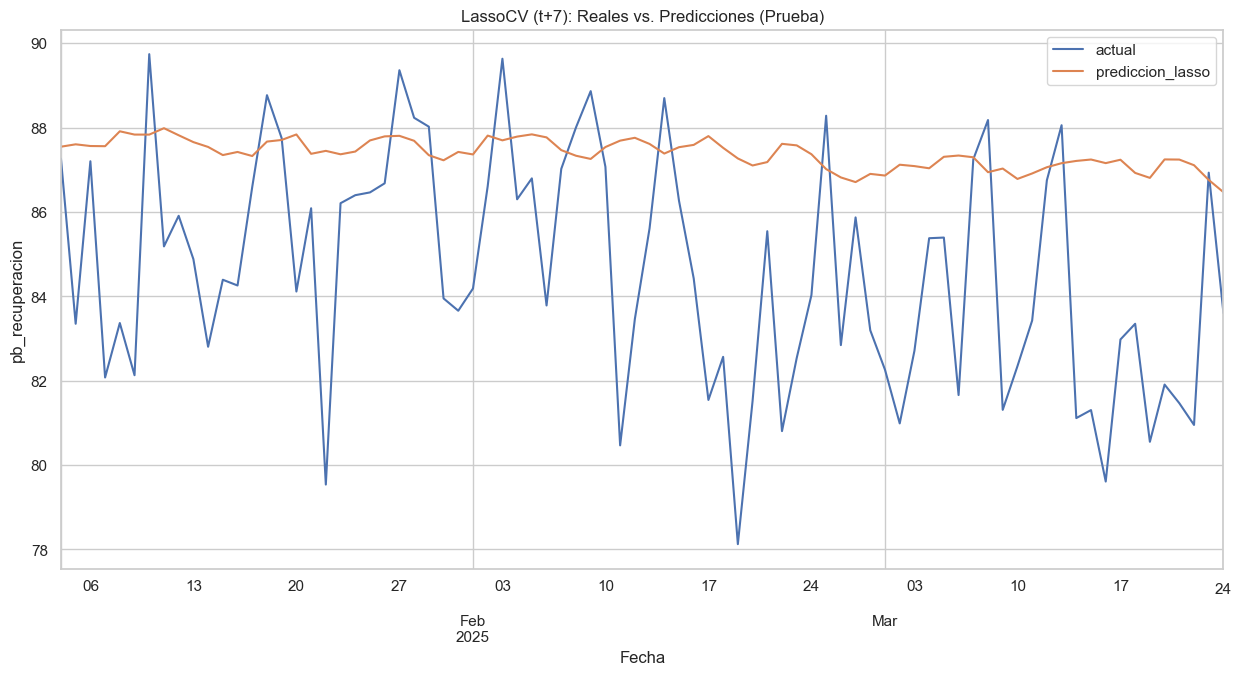

In [130]:
# --- BLOQUE DE EJECUCIÓN DE EJEMPLO PARA LASSOCV ---

# Asumimos que 'df_con_features' y 'columna_a_analizar' están disponibles.
# Si no, cárgalos o genéralos como en los ejemplos anteriores.
# Ejemplo:
# if not ('df_con_features' in locals() and df_con_features is not None and \
#    'columna_a_analizar' in locals() and columna_a_analizar is not None):
#     print("Cargando/Generando df_con_features y definiendo columna_a_analizar...")
#     # Aquí iría tu código para cargar df_con_features (ej. desde un pickle o regenerándolo)
#     # df_con_features = pd.read_pickle("ruta/a/df_con_features.pkl") 
#     # columna_a_analizar = 'pb_recuperacion'
#     if not ('df_con_features' in locals() and df_con_features is not None):
#          print("ERROR: df_con_features no está disponible.")
#          df_con_features = None 


if 'df_con_features' in locals() and isinstance(df_con_features, pd.DataFrame) and \
   'columna_a_analizar' in locals() and isinstance(columna_a_analizar, str):

    print(f"Preparando para modelar con LassoCV para: {columna_a_analizar}")
    print(f"DataFrame de entrada con features: {df_con_features.shape}")

    HORIZONTE_PRONOSTICO_LASSO = 7
    TAMANO_CONJUNTO_TEST_LASSO = 0.2
    NUM_CV_SPLITS_LASSO = 5 # Para TimeSeriesSplit dentro de LassoCV

    metricas_lasso, modelo_lasso, df_predicciones_lasso, features_sel_lasso = entrenar_evaluar_lasso_cv(
        df_con_features=df_con_features,
        nombre_col_objetivo=columna_a_analizar,
        horizonte_pronostico=HORIZONTE_PRONOSTICO_LASSO,
        tamano_test=TAMANO_CONJUNTO_TEST_LASSO,
        n_cv_splits=NUM_CV_SPLITS_LASSO,
        random_state=42
    )

    if metricas_lasso:
        print(f"\n--- Resultados de LassoCV (t+{HORIZONTE_PRONOSTICO_LASSO}) ---")
        
        if df_predicciones_lasso is not None and not df_predicciones_lasso.empty:
            print("\nPrimeras filas del DataFrame de predicciones:")
            print(df_predicciones_lasso.head())
            
            df_predicciones_lasso.plot(figsize=(15, 7), title=f"LassoCV (t+{HORIZONTE_PRONOSTICO_LASSO}): Reales vs. Predicciones (Prueba)")
            plt.ylabel(columna_a_analizar)
            plt.xlabel("Fecha")
            plt.legend()
            plt.grid(True)
            plt.show()
else:
    print("Por favor, asegúrate de que 'df_con_features' y 'columna_a_analizar' estén disponibles y correctamente definidos.")
    print("Necesitas ejecutar los pasos de preprocesamiento y generación de características primero.")

#### SARIMAX

In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm # Para SARIMAX
import pmdarima as pm       # Para auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- Función SMAPE ---
def smape_v2(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    epsilon = np.finfo(np.float64).eps 
    smape_values = 2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)
    return np.mean(smape_values) * 100

# --- Función para Validación Walk-Forward con SARIMAX y Auto ARIMA inicial ---
def ejecutar_walk_forward_sarimax_con_auto_arima(
    df_completo_con_features, 
    nombre_col_objetivo_original, 
    lista_nombres_exogenas_deterministicas,
    pasos_a_pronosticar_horizonte=7, 
    proporcion_entrenamiento_inicial=0.7,
    scale_exog=True,
    # Parámetros para auto_arima
    auto_arima_d=None, # Permitir que auto_arima encuentre d
    auto_arima_D=None, # Permitir que auto_arima encuentre D
    auto_arima_max_p=3, auto_arima_max_q=3,
    auto_arima_max_P=2, auto_arima_max_Q=2
):
    print(f"--- Iniciando Walk-Forward para SARIMAX con Auto ARIMA inicial (evaluando t+{pasos_a_pronosticar_horizonte}) ---")
    
    # 1. Preparar datos endógenos y exógenos (como antes)
    endog_series_original = df_completo_con_features[nombre_col_objetivo_original]
    exog_df_seleccionadas = None
    if lista_nombres_exogenas_deterministicas and len(lista_nombres_exogenas_deterministicas) > 0:
        exogenas_existentes = [col for col in lista_nombres_exogenas_deterministicas if col in df_completo_con_features.columns]
        if exogenas_existentes: exog_df_seleccionadas = df_completo_con_features[exogenas_existentes].copy()
    
    exog_df_scaled = None
    if exog_df_seleccionadas is not None and scale_exog:
        scaler_exog = StandardScaler()
        exog_df_scaled = pd.DataFrame(scaler_exog.fit_transform(exog_df_seleccionadas), 
                                      index=exog_df_seleccionadas.index, columns=exog_df_seleccionadas.columns)
    elif exog_df_seleccionadas is not None:
        exog_df_scaled = exog_df_seleccionadas

    if exog_df_scaled is not None:
        datos_alineados = pd.concat([endog_series_original, exog_df_scaled], axis=1).dropna()
        endog_all = datos_alineados[nombre_col_objetivo_original]
        exog_all_aligned_scaled = datos_alineados.drop(columns=[nombre_col_objetivo_original])
    else:
        endog_all = endog_series_original.dropna()
        exog_all_aligned_scaled = None
    
    min_obs_entrenamiento = 30 # Un mínimo para auto_arima y el primer entrenamiento
    if len(endog_all) < int(len(df_completo_con_features) * proporcion_entrenamiento_inicial) + pasos_a_pronosticar_horizonte + min_obs_entrenamiento:
        print("Datos insuficientes después de NaNs para validación walk-forward.")
        return None, None, None

    # 2. Dividir en el primer conjunto de entrenamiento para auto_arima
    tamano_entrenamiento_inicial_auto_arima = int(len(endog_all) * proporcion_entrenamiento_inicial)
    if tamano_entrenamiento_inicial_auto_arima < min_obs_entrenamiento:
        print(f"El tamaño de entrenamiento inicial ({tamano_entrenamiento_inicial_auto_arima}) es muy pequeño para auto_arima. "
              f"Se necesitan al menos {min_obs_entrenamiento} puntos.")
        return None, None, None

    endog_entrenamiento_auto_arima = endog_all.iloc[:tamano_entrenamiento_inicial_auto_arima]
    exog_entrenamiento_auto_arima = exog_all_aligned_scaled.iloc[:tamano_entrenamiento_inicial_auto_arima] if exog_all_aligned_scaled is not None else None

    print(f"Ejecutando auto_arima en el conjunto de entrenamiento inicial (tamaño: {len(endog_entrenamiento_auto_arima)})...")
    
    # 3. Ejecutar auto_arima para encontrar los mejores órdenes
    try:
        auto_model = pm.auto_arima(
            endog_entrenamiento_auto_arima,
            exogenous=exog_entrenamiento_auto_arima,
            start_p=1, start_q=1, max_p=auto_arima_max_p, max_q=auto_arima_max_q,
            start_P=1, start_Q=1, max_P=auto_arima_max_P, max_Q=auto_arima_max_Q,
            m=7, # Periodo estacional
            seasonal=True,
            d=auto_arima_d, # None para que lo determine auto_arima
            D=auto_arima_D, # None para que lo determine auto_arima
            test='adf', # Prueba para d
            seasonal_test='ocsb', # Prueba para D
            trace=True, # Muestra los modelos que prueba
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True # Búsqueda más rápida
        )
        
        print(auto_model.summary())
        orden_optima = auto_model.order
        orden_estacional_optima = auto_model.seasonal_order
        print(f"Órdenes encontrados por auto_arima: order={orden_optima}, seasonal_order={orden_estacional_optima}")
    except Exception as e:
        print(f"Error durante auto_arima: {e}. Usando órdenes por defecto (1,0,1)(1,0,1,7).")
        orden_optima = (1,0,1)
        orden_estacional_optima = (1,0,1,7)


    # 4. Bucle de Validación Walk-Forward usando los órdenes encontrados
    predicciones_target_horizonte = []
    reales_target_horizonte = []
    indices_target_horizonte = []
    
    num_pronosticos_posibles = len(endog_all) - tamano_entrenamiento_inicial_auto_arima - pasos_a_pronosticar_horizonte + 1
    if num_pronosticos_posibles <= 0:
        print("No hay suficientes datos para generar pronósticos walk-forward con los órdenes encontrados.")
        return None, auto_model if 'auto_model' in locals() else None, None
        
    print(f"\nIniciando validación walk-forward con órdenes {orden_optima}{orden_estacional_optima}...")
    print(f"Número de pronósticos walk-forward de {pasos_a_pronosticar_horizonte} pasos a generar: {num_pronosticos_posibles}")

    for i in range(num_pronosticos_posibles):
        indice_fin_entrenamiento = tamano_entrenamiento_inicial_auto_arima + i
        
        endog_entrenamiento_actual = endog_all.iloc[:indice_fin_entrenamiento]
        exog_entrenamiento_actual = exog_all_aligned_scaled.iloc[:indice_fin_entrenamiento] if exog_all_aligned_scaled is not None else None
        
        indice_inicio_pronostico_exog = indice_fin_entrenamiento
        indice_fin_pronostico_exog = indice_fin_entrenamiento + pasos_a_pronosticar_horizonte
        exogenas_para_pronostico = exog_all_aligned_scaled.iloc[indice_inicio_pronostico_exog:indice_fin_pronostico_exog] if exog_all_aligned_scaled is not None else None
        
        if exogenas_para_pronostico is not None and len(exogenas_para_pronostico) < pasos_a_pronosticar_horizonte:
            print(f"Advertencia en paso {i+1}: exógenas insuficientes ({len(exogenas_para_pronostico)}) para horizonte {pasos_a_pronosticar_horizonte}. Omitiendo.")
            continue

        try:
            modelo_statsmodels = sm.tsa.SARIMAX(endog_entrenamiento_actual, exog=exog_entrenamiento_actual,
                                                order=orden_optima, seasonal_order=orden_estacional_optima,
                                                enforce_stationarity=False, enforce_invertibility=False)
            modelo_ajustado_statsmodels = modelo_statsmodels.fit(disp=False)
            pronostico_multipasos = modelo_ajustado_statsmodels.get_forecast(steps=pasos_a_pronosticar_horizonte, exog=exogenas_para_pronostico)
            prediccion_en_horizonte_N = pronostico_multipasos.predicted_mean.iloc[pasos_a_pronosticar_horizonte-1]
        except Exception as e:
            print(f"Error ajustando o pronosticando con SARIMAX (statsmodels) en paso {i+1}: {e}. Omitiendo.")
            prediccion_en_horizonte_N = np.nan

        indice_real_futuro = indice_fin_entrenamiento + pasos_a_pronosticar_horizonte - 1
        valor_real_en_horizonte_N = endog_all.iloc[indice_real_futuro]
        
        predicciones_target_horizonte.append(prediccion_en_horizonte_N)
        reales_target_horizonte.append(valor_real_en_horizonte_N)
        indices_target_horizonte.append(endog_all.index[indice_real_futuro])

        if (i + 1) % 20 == 0: print(f"Validación Walk-Forward SARIMAX: Paso {i + 1}/{num_pronosticos_posibles} completado.")

    print("Validación walk-forward para SARIMAX con Auto ARIMA inicial finalizada.")

    # 5. Evaluación (como antes)
    # ... (resto del código de evaluación y graficación igual que en la función SARIMAX anterior) ...
    if not predicciones_target_horizonte: return None, None, None
    df_resultados_temp = pd.DataFrame({'real': reales_target_horizonte, 'pred': predicciones_target_horizonte}).dropna()
    reales_np = df_resultados_temp['real'].to_numpy(); predicciones_np = df_resultados_temp['pred'].to_numpy()
    metricas = {}; df_resultados_plot = None
    if len(predicciones_np) > 0:
        metricas['wf_mae'] = mean_absolute_error(reales_np, predicciones_np)
        metricas['wf_rmse'] = np.sqrt(mean_squared_error(reales_np, predicciones_np))
        metricas['wf_mape'] = mean_absolute_percentage_error(reales_np, predicciones_np) * 100
        metricas['wf_smape'] = smape_v2(reales_np, predicciones_np)
        print(f'\nPronóstico para t+{pasos_a_pronosticar_horizonte} con SARIMAX (Auto Órdenes, Walk-Forward):')
        for nombre_metrica, valor in metricas.items(): print(f"{nombre_metrica}: {valor:.4f}")
        df_resultados_plot = pd.DataFrame({'actual': reales_target_horizonte, 'prediccion_sarimax_wf': predicciones_target_horizonte}, index=pd.Index(indices_target_horizonte, name=endog_all.index.name))
    else: print("No hay predicciones válidas para calcular métricas.")
    
    return metricas, auto_model if 'auto_model' in locals() else None, df_resultados_plot

Ejecutando SARIMAX con Auto ARIMA para la columna: pb_recuperacion
Usando 13 features exógenas para SARIMAX con AutoARIMA.
--- Iniciando Walk-Forward para SARIMAX con Auto ARIMA inicial (evaluando t+14) ---
Ejecutando auto_arima en el conjunto de entrenamiento inicial (tamaño: 294)...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=1543.876, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1626.923, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1499.039, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1531.630, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3462.556, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1510.917, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=1503.604, Time=1.24 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1524.514, Time=0.54 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1501.291, Time=0.31 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=1524.504, Time=1.78 sec
 ARIMA(0,0,

D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarn

Validación Walk-Forward SARIMAX: Paso 20/114 completado.


D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Validación Walk-Forward SARIMAX: Paso 40/114 completado.


D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Validación Walk-Forward SARIMAX: Paso 60/114 completado.


D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Validación Walk-Forward SARIMAX: Paso 80/114 completado.


D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Validación Walk-Forward SARIMAX: Paso 100/114 completado.


D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarn

Validación walk-forward para SARIMAX con Auto ARIMA inicial finalizada.

Pronóstico para t+14 con SARIMAX (Auto Órdenes, Walk-Forward):
wf_mae: 104.1443
wf_rmse: 172.1123
wf_mape: 122.9036
wf_smape: 84.7373

--- Resultados Walk-Forward SARIMAX con AutoARIMA (evaluando t+14) ---

Resumen del modelo encontrado por auto_arima (en el primer split de entrenamiento):
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  294
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 7)   Log Likelihood                -242.209
Date:                            Fri, 30 May 2025   AIC                            500.419
Time:                                    14:28:22   BIC                            529.887
Sample:                                         0   HQIC                           512.220
                                            - 294                                         

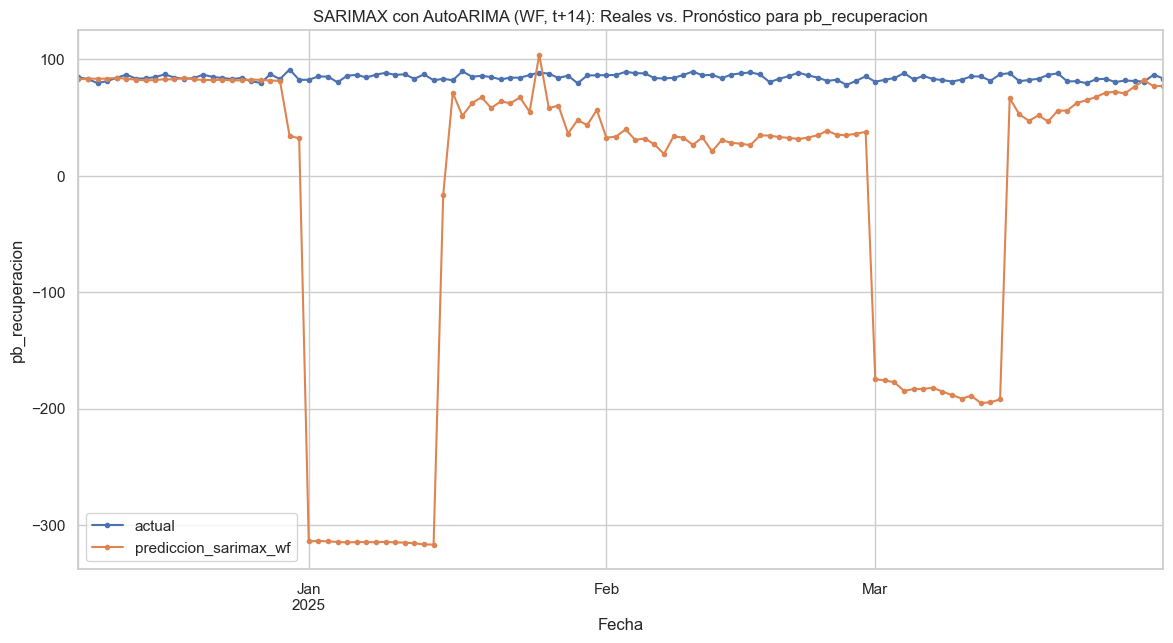

In [89]:
# --- BLOQUE DE EJECUCIÓN DE EJEMPLO ---
# (Asegúrate de que 'serie_procesada', 'generar_caracteristicas_temporales', 'smape_v2' estén definidas)

if 'serie_procesada' in locals() and isinstance(serie_procesada, pd.Series) and \
   'columna_objetivo_original' in locals() and isinstance(columna_objetivo_original, str):

    print(f"Ejecutando SARIMAX con Auto ARIMA para la columna: {columna_objetivo_original}")

    # Generar características primero
    df_para_features_inicial = serie_procesada.to_frame(name=columna_objetivo_original)
    df_con_features = generar_caracteristicas_temporales(
        df_entrada=df_para_features_inicial,
        nombre_columna_objetivo=columna_objetivo_original,
        num_lags=num_lags_para_features, # Definido previamente
        ventanas_rolling=[3, 5, 7, 14, 21, 28], 
        periodo_estacional_principal=7
    )

    HORIZONTE_REAL_SARIMAX_AUTO = n_steps_ahead 
    PROPORCION_ENTRENAMIENTO_INICIAL_AUTO = 0.7
    
    fourier_cols_sx_auto = [col for col in df_con_features.columns if col.startswith('sin_semanal_') or col.startswith('cos_semanal_')]
    calendar_other_cols_sx_auto = ['tendencia_idx', 'dia_mes', 'mes', 'ano', 'trimestre', 'semana_iso', 'dia_ano']
    nombres_exogenas_sarimax_auto = fourier_cols_sx_auto + calendar_other_cols_sx_auto
    nombres_exogenas_sarimax_auto = [col for col in nombres_exogenas_sarimax_auto if col in df_con_features.columns]

    if not nombres_exogenas_sarimax_auto: print("ADVERTENCIA: No exógenas. SARIMAX -> SARIMA.")
    else: print(f"Usando {len(nombres_exogenas_sarimax_auto)} features exógenas para SARIMAX con AutoARIMA.")

    # Ejecutar el modelo con auto_arima
    metricas_sx_auto, modelo_auto_arima_fit, df_resultados_sx_auto = ejecutar_walk_forward_sarimax_con_auto_arima(
        df_completo_con_features=df_con_features, 
        nombre_col_objetivo_original=columna_objetivo_original,
        lista_nombres_exogenas_deterministicas=nombres_exogenas_sarimax_auto,
        pasos_a_pronosticar_horizonte=HORIZONTE_REAL_SARIMAX_AUTO,
        proporcion_entrenamiento_inicial=PROPORCION_ENTRENAMIENTO_INICIAL_AUTO,
        scale_exog=True,
        # Puedes ajustar los límites de búsqueda de auto_arima aquí si es necesario
        # auto_arima_max_p=5, auto_arima_max_q=5 # Ejemplo
    )

    if metricas_sx_auto:
        print(f"\n--- Resultados Walk-Forward SARIMAX con AutoARIMA (evaluando t+{HORIZONTE_REAL_SARIMAX_AUTO}) ---")
        if modelo_auto_arima_fit: # modelo_auto_arima_fit será el resultado de pm.auto_arima
             print("\nResumen del modelo encontrado por auto_arima (en el primer split de entrenamiento):")
             print(modelo_auto_arima_fit.summary())

        if df_resultados_sx_auto is not None and not df_resultados_sx_auto.empty:
            print("\nPrimeras filas del DataFrame de pronóstico SARIMAX (AutoARIMA):")
            print(df_resultados_sx_auto.head())
            
            df_resultados_sx_auto.plot(figsize=(14, 7), marker='.')
            plt.title(f"SARIMAX con AutoARIMA (WF, t+{HORIZONTE_REAL_SARIMAX_AUTO}): Reales vs. Pronóstico para {columna_objetivo_original}")
            plt.ylabel(columna_objetivo_original)
            plt.xlabel("Fecha")
            plt.legend()
            plt.grid(True)
            plt.show()
    elif modelo_auto_arima_fit:
        print("El modelo auto_arima fue ajustado, pero no se generaron resultados de pronóstico evaluables.")
else:
    print("Por favor, asegúrate de que 'serie_procesada', etc., estén disponibles.")

#### Random Forest

Forma de X_all después de la preparación: (400, 54)
Forma de y_all después de la preparación: (400,)

Iniciando validación walk-forward para pronóstico de t+7...
Tamaño total después de preparación: 400
Tamaño de entrenamiento inicial: 280
Tamaño de prueba (orígenes de pronóstico): 120
Validación walk-forward finalizada.

Pronóstico para t+7 con validación walk-forward y normalización:
MAE: 2.2834
RMSE: 2.8927
MAPE: 0.0271
SMAPE: 2.70%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


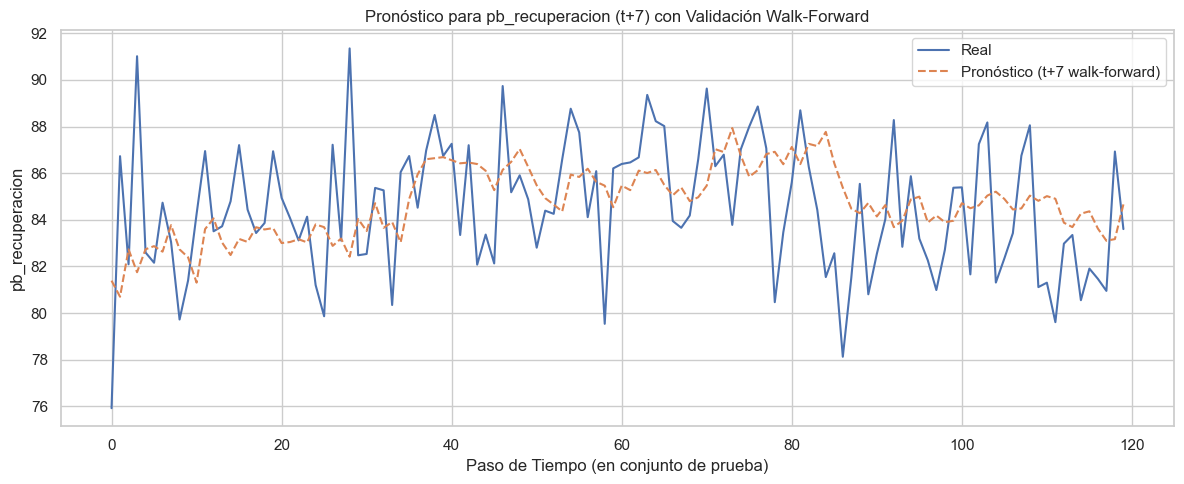

In [50]:
# 2. Crear la VERDADERA variable objetivo para t+N (ej. t+14)
horizonte_real = 7 # O el n_steps_ahead que desees
df_para_modelo = df_con_features.copy()
df_para_modelo['objetivo_futuro_t_mas_N'] = df_para_modelo['pb_recuperacion'].shift(-horizonte_real)

X = df_para_modelo.drop(columns=['pb_recuperacion', 'objetivo_futuro_t_mas_N'])
y = df_para_modelo['objetivo_futuro_t_mas_N']

# 4. Eliminar NaNs DESPUÉS de crear el objetivo futuro y definir X.
#    Esto eliminará las filas donde las features no se pudieron calcular (inicio)
#    Y donde el objetivo futuro no existe (final).
df_final_para_modelo = pd.concat([X, y], axis=1).dropna()

# 5. Ahora, separa de nuevo X e y para el modelo a partir de df_final_para_modelo
y_final = df_final_para_modelo[y.name] # y.name será 'objetivo_futuro_t_mas_N'
X_final = df_final_para_modelo.drop(columns=[y.name])

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

columna = 'pb_recuperacion' # Columna a pronosticar
n_lags = 15                  # Número de lags para usar como características
n_steps_ahead = 7          # Horizonte de pronóstico (t+10)

# Separar X_all (características finales) e y_all (objetivo final)
X_all = X_final
y_all = y_final

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X.columns)

# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_features='sqrt', min_samples_split=5, min_samples_leaf=3)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### LightGBM

Forma de X_all después de la preparación: (400, 54)
Forma de y_all después de la preparación: (400,)

Iniciando validación walk-forward para pronóstico de t+7...
Tamaño total después de preparación: 400
Tamaño de entrenamiento inicial: 280
Tamaño de prueba (orígenes de pronóstico): 120
Validación walk-forward finalizada.

Pronóstico para t+7 con validación walk-forward y normalización:
MAE: 2.2827
RMSE: 2.9963
MAPE: 0.0271
SMAPE: 2.70%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


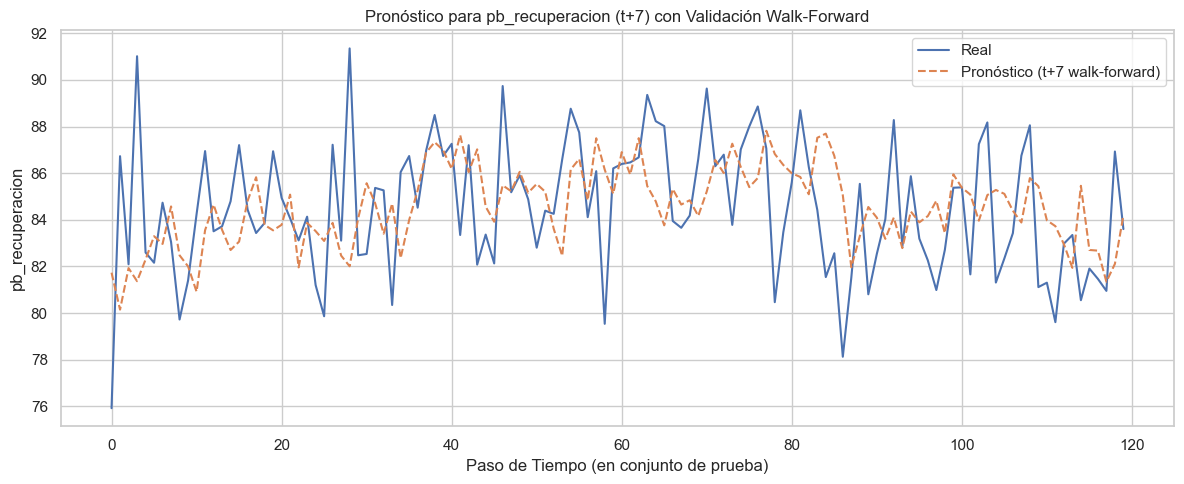

In [52]:
import pandas as pd
import numpy as np
import lightgbm as lgb # Importar LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 2. Crear la VERDADERA variable objetivo para t+N (ej. t+14)
horizonte_real = 7 # O el n_steps_ahead que desees
df_para_modelo = df_con_features.copy()
df_para_modelo['objetivo_futuro_t_mas_N'] = df_para_modelo['pb_recuperacion'].shift(-horizonte_real)

X = df_para_modelo.drop(columns=['pb_recuperacion', 'objetivo_futuro_t_mas_N'])
y = df_para_modelo['objetivo_futuro_t_mas_N']

# 4. Eliminar NaNs DESPUÉS de crear el objetivo futuro y definir X.
#    Esto eliminará las filas donde las features no se pudieron calcular (inicio)
#    Y donde el objetivo futuro no existe (final).
df_final_para_modelo = pd.concat([X, y], axis=1).dropna()

# 5. Ahora, separa de nuevo X e y para el modelo a partir de df_final_para_modelo
y_final = df_final_para_modelo[y.name] # y.name será 'objetivo_futuro_t_mas_N'
X_final = df_final_para_modelo.drop(columns=[y.name])

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

columna = 'pb_recuperacion' # Columna a pronosticar
n_lags = 15                 # Número de lags para usar como características
n_steps_ahead = 7          # Horizonte de pronóstico (t+10)

# Separar X_all (características finales) e y_all (objetivo final)
X_all = X_final
y_all = y_final

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X.columns)

# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead

    model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=31, random_state=42, n_jobs=-1, verbose=-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### XGBoost

In [54]:
# 2. Crear la VERDADERA variable objetivo para t+N (ej. t+14)
horizonte_real = 7 # O el n_steps_ahead que desees
df_para_modelo = df_con_features.copy()
df_para_modelo['objetivo_futuro_t_mas_N'] = df_para_modelo['pb_recuperacion'].shift(-horizonte_real)

X = df_para_modelo.drop(columns=['pb_recuperacion', 'objetivo_futuro_t_mas_N'])
y = df_para_modelo['objetivo_futuro_t_mas_N']

# 4. Eliminar NaNs DESPUÉS de crear el objetivo futuro y definir X.
#    Esto eliminará las filas donde las features no se pudieron calcular (inicio)
#    Y donde el objetivo futuro no existe (final).
df_final_para_modelo = pd.concat([X, y], axis=1).dropna()

# 5. Ahora, separa de nuevo X e y para el modelo a partir de df_final_para_modelo
y_final = df_final_para_modelo[y.name] # y.name será 'objetivo_futuro_t_mas_N'
X_final = df_final_para_modelo.drop(columns=[y.name])

In [56]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

columna = 'pb_recuperacion' # Columna a pronosticar
n_lags = 15                  # Número de lags para usar como características
n_steps_ahead = 7          # Horizonte de pronóstico (t+10)

In [58]:
# Separar X_all (características finales) e y_all (objetivo final)
X_all = X_final
y_all = y_final

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

Forma de X_all después de la preparación: (400, 54)
Forma de y_all después de la preparación: (400,)


In [60]:
print(X_all.columns)

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'rolling_mean_3', 'rolling_std_3', 'rolling_min_3', 'rolling_max_3',
       'rolling_mean_5', 'rolling_std_5', 'rolling_min_5', 'rolling_max_5',
       'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_min_14', 'rolling_max_14',
       'dia_semana', 'dia_mes', 'dia_ano', 'mes', 'trimestre', 'semana_iso',
       'ano', 'dia_sem_0', 'dia_sem_1', 'dia_sem_2', 'dia_sem_3', 'dia_sem_4',
       'dia_sem_5', 'dia_sem_6', 'sin_semanal_1', 'cos_semanal_1',
       'sin_semanal_2', 'cos_semanal_2', 'sin_semanal_3', 'cos_semanal_3',
       'tendencia_idx', 'diff_1', 'diff_estacional_7', 'momentum_custom_4'],
      dtype='object')


In [62]:
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X.columns)


In [64]:
print(X_all_scaled.columns)

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'rolling_mean_3', 'rolling_std_3', 'rolling_min_3', 'rolling_max_3',
       'rolling_mean_5', 'rolling_std_5', 'rolling_min_5', 'rolling_max_5',
       'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_min_14', 'rolling_max_14',
       'dia_semana', 'dia_mes', 'dia_ano', 'mes', 'trimestre', 'semana_iso',
       'ano', 'dia_sem_0', 'dia_sem_1', 'dia_sem_2', 'dia_sem_3', 'dia_sem_4',
       'dia_sem_5', 'dia_sem_6', 'sin_semanal_1', 'cos_semanal_1',
       'sin_semanal_2', 'cos_semanal_2', 'sin_semanal_3', 'cos_semanal_3',
       'tendencia_idx', 'diff_1', 'diff_estacional_7', 'momentum_custom_4'],
      dtype='object')


In [66]:
# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

In [68]:

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead

    model = XGBRegressor(n_estimators=300,learning_rate=0.1,max_depth=4,subsample=0.8,colsample_bytree=0.8,gamma=0.1,objective='reg:squarederror',random_state=42,n_jobs=-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")


Iniciando validación walk-forward para pronóstico de t+7...
Tamaño total después de preparación: 400
Tamaño de entrenamiento inicial: 280
Tamaño de prueba (orígenes de pronóstico): 120
Validación walk-forward finalizada.


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Pronóstico para t+7 con validación walk-forward y normalización:
MAE: 2.4267
RMSE: 3.0728
MAPE: 0.0287
SMAPE: 2.87%


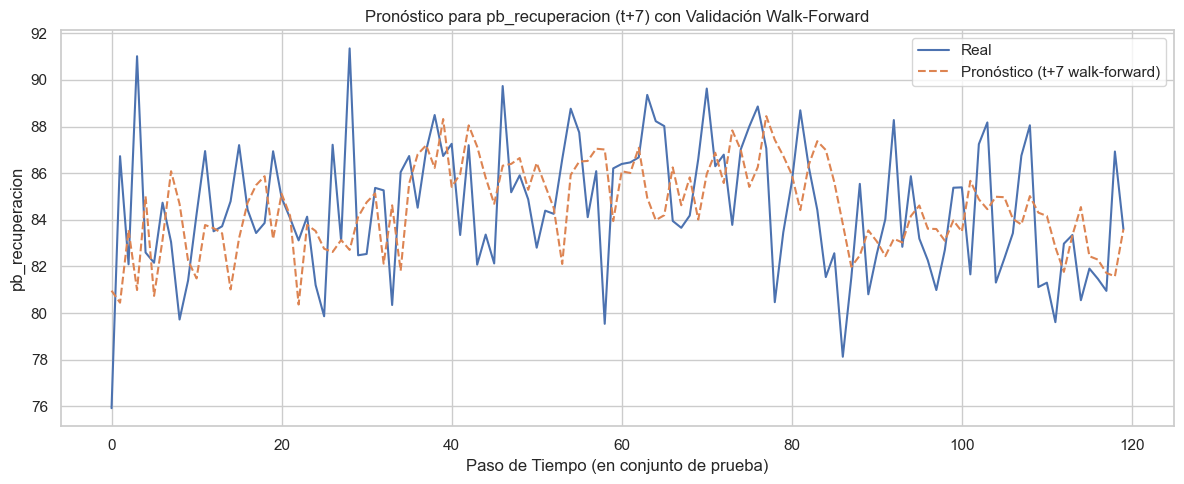

In [70]:
y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### LSTM

Preparando para modelar con LSTM para: pb_recuperacion
DataFrame con features para LSTM: (421, 71)
ADVERTENCIA: El entrenamiento de LSTM en un bucle walk-forward puede ser LENTO.
--- Iniciando Validación Walk-Forward para LSTM (t+14) ---
Forma de X_all_scaled_np (features): (377, 69)
Forma de y_all_reset (objetivo futuro): (377,)
Tamaño total: 377, Entrenamiento inicial: 263, Prueba: 114


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validación Walk-Forward LSTM: Paso 20/114 completado.
Validación Walk-Forward LSTM: Paso 40/114 completado.
Validación Walk-Forward LSTM: Paso 60/114 completado.
Validación Walk-Forward LSTM: Paso 80/114 completado.
Validación Walk-Forward LSTM: Paso 100/114 completado.
Validación walk-forward para LSTM finalizada.

Pronóstico para t+14 con LSTM (Walk-Forward):
wf_mae: 66.1639
wf_rmse: 66.7217
wf_mape: 78.1569
wf_smape: 130.1592

--- Resultados Walk-Forward LSTM (t+14) ---

Resumen del último modelo LSTM ajustado:

Primeras filas del DataFrame de pronóstico LSTM:
               actual  prediccion_lstm_wf
date_index                               
2024-11-19  84.735081           14.489939
2024-11-20  83.048027           13.232860
2024-11-21  79.722870           11.028619
2024-11-22  81.395160           13.626347
2024-11-23  84.243949            8.429459


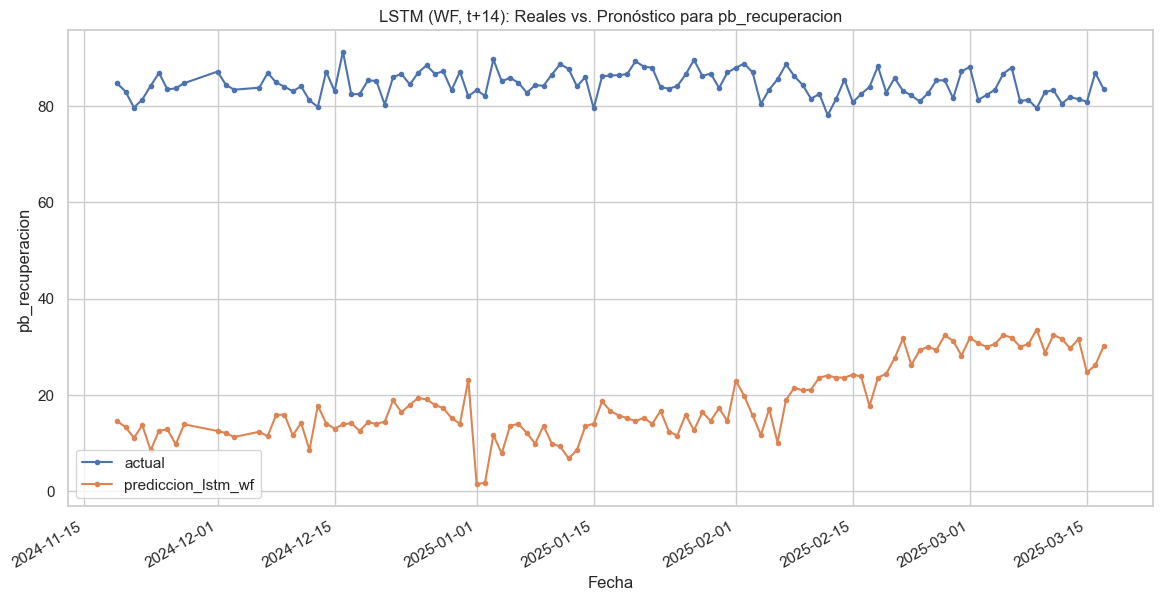

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# TensorFlow y Keras para LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configurar para reproducibilidad (opcional pero recomendado para NNs)
tf.random.set_seed(42)
np.random.seed(42)

# --- Función SMAPE ---
def smape_v2(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    epsilon = np.finfo(np.float64).eps 
    smape_values = 2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)
    return np.mean(smape_values) * 100

# --- Función para construir el modelo LSTM ---
def construir_modelo_lstm_simple(input_shape_timesteps, input_shape_features, lstm_units=32, dropout_rate=0.2):
    modelo = Sequential()
    modelo.add(LSTM(lstm_units, input_shape=(input_shape_timesteps, input_shape_features)))
    if dropout_rate > 0:
        modelo.add(Dropout(dropout_rate))
    modelo.add(Dense(1)) # Capa de salida para regresión
    modelo.compile(optimizer='adam', loss='mse') # Usar Mean Squared Error para regresión
    return modelo

# --- Función Principal para LSTM con Walk-Forward ---
def ejecutar_walk_forward_lstm(
    df_completo_con_features, 
    nombre_col_objetivo_original, 
    pasos_a_pronosticar_horizonte=7, 
    proporcion_entrenamiento_inicial=0.7,
    # Hiperparámetros LSTM
    lstm_units=32,
    dropout_rate=0.2,
    epochs_lstm=20, # Número de épocas por cada reentrenamiento (mantener bajo)
    batch_size_lstm=16 
):
    print(f"--- Iniciando Validación Walk-Forward para LSTM (t+{pasos_a_pronosticar_horizonte}) ---")
    
    # 1. Preparar X e y (misma lógica que para los otros modelos)
    datos = df_completo_con_features.copy()
    nombre_col_objetivo_futuro = f"objetivo_{nombre_col_objetivo_original}_t_mas_{pasos_a_pronosticar_horizonte}"
    datos[nombre_col_objetivo_futuro] = datos[nombre_col_objetivo_original].shift(-pasos_a_pronosticar_horizonte)
    columnas_a_excluir_para_X = [nombre_col_objetivo_original, nombre_col_objetivo_futuro]
    if 'dia_semana' in datos.columns and (any(col.startswith('dia_sem_') for col in datos.columns) or any(col.startswith('sin_semanal_') for col in datos.columns)):
        if 'dia_semana' not in columnas_a_excluir_para_X: columnas_a_excluir_para_X.append('dia_semana')
    X_preliminar = datos.drop(columns=columnas_a_excluir_para_X, errors='ignore')
    y_preliminar = datos[nombre_col_objetivo_futuro]
    df_para_modelo_final = pd.concat([X_preliminar, y_preliminar], axis=1)
    df_para_modelo_final = df_para_modelo_final.astype({col: int for col in df_para_modelo_final.select_dtypes(include=['bool']).columns}, errors='ignore')
    df_para_modelo_final = df_para_modelo_final.astype('float64', errors='ignore') 
    df_para_modelo_final = df_para_modelo_final.dropna()

    if df_para_modelo_final.empty or len(df_para_modelo_final) < 20:
        print("ERROR: df_para_modelo_final vacío o con muy pocos datos.")
        return None, None, None

    y_all = df_para_modelo_final[nombre_col_objetivo_futuro]
    X_all = df_para_modelo_final.drop(columns=[nombre_col_objetivo_futuro])
    
    if nombre_col_objetivo_futuro in X_all.columns or nombre_col_objetivo_original in X_all.columns:
        print(f"¡¡¡ERROR DE FUGA DE DATOS POTENCIAL!!! Verifique X_all.")
        exit()

    X_all_original_index = X_all.index 
    X_all_reset = X_all.reset_index(drop=True)
    y_all_reset = y_all.reset_index(drop=True)

    scaler = StandardScaler()
    X_all_scaled_np = scaler.fit_transform(X_all_reset) # Numpy array
    n_features = X_all_scaled_np.shape[1]
    print(f"Forma de X_all_scaled_np (features): {X_all_scaled_np.shape}")
    print(f"Forma de y_all_reset (objetivo futuro): {y_all_reset.shape}")

    # 2. Configuración y Bucle Walk-Forward
    tamano_entrenamiento_inicial = int(len(X_all_scaled_np) * proporcion_entrenamiento_inicial)
    predicciones_lstm = []
    reales_lstm = []
    indices_prueba_lstm = []

    total_puntos_prueba = len(X_all_scaled_np) - tamano_entrenamiento_inicial
    if total_puntos_prueba <= 0:
        print("Error: No hay datos de prueba. Ajusta 'proporcion_entrenamiento_inicial'.")
        return None, None, None
    print(f"Tamaño total: {len(X_all_scaled_np)}, Entrenamiento inicial: {tamano_entrenamiento_inicial}, Prueba: {total_puntos_prueba}")

    # --- Parámetros LSTM ---
    n_input_timesteps_lstm = 1 # Cada fila de X_all_scaled es un "paso de tiempo" con todas las features

    for i in range(tamano_entrenamiento_inicial, len(X_all_scaled_np)): 
        X_train_np = X_all_scaled_np[:i]
        y_train_np = y_all_reset.iloc[:i].values # Keras prefiere numpy arrays
        
        # Reformatear X_train para LSTM: (samples, timesteps, features)
        X_train_lstm = X_train_np.reshape((X_train_np.shape[0], n_input_timesteps_lstm, n_features))
        
        X_test_current_step_np = X_all_scaled_np[i:i+1]
        # Reformatear X_test_current_step para LSTM
        X_test_current_step_lstm = X_test_current_step_np.reshape((1, n_input_timesteps_lstm, n_features))
        
        y_actual_current_step = y_all_reset.iloc[i]

        # Construir y entrenar el modelo LSTM en cada paso
        modelo_lstm = construir_modelo_lstm_simple(n_input_timesteps_lstm, n_features, lstm_units, dropout_rate)
        
        # print(f"Entrenando LSTM para el paso walk-forward {i - tamano_entrenamiento_inicial + 1}/{total_puntos_prueba}...")
        modelo_lstm.fit(X_train_lstm, y_train_np, epochs=epochs_lstm, batch_size=batch_size_lstm, verbose=0)
        
        y_pred = modelo_lstm.predict(X_test_current_step_lstm, verbose=0)[0,0] # [0,0] para obtener el valor escalar
        
        predicciones_lstm.append(y_pred)
        reales_lstm.append(y_actual_current_step)
        indices_prueba_lstm.append(X_all_original_index[i])

        if (i - tamano_entrenamiento_inicial + 1) % 20 == 0: # Imprimir progreso
            print(f"Validación Walk-Forward LSTM: Paso {i - tamano_entrenamiento_inicial + 1}/{total_puntos_prueba} completado.")
    
    print("Validación walk-forward para LSTM finalizada.")

    # 3. Evaluación
    predicciones_np_lstm = np.array(predicciones_lstm)
    reales_np_lstm = np.array(reales_lstm)
    
    metricas = {}
    if len(predicciones_np_lstm) > 0:
        metricas['wf_mae'] = mean_absolute_error(reales_np_lstm, predicciones_np_lstm)
        metricas['wf_rmse'] = np.sqrt(mean_squared_error(reales_np_lstm, predicciones_np_lstm))
        metricas['wf_mape'] = mean_absolute_percentage_error(reales_np_lstm, predicciones_np_lstm) * 100
        metricas['wf_smape'] = smape_v2(reales_np_lstm, predicciones_np_lstm)

        print(f'\nPronóstico para t+{pasos_a_pronosticar_horizonte} con LSTM (Walk-Forward):')
        for nombre_metrica, valor in metricas.items(): print(f"{nombre_metrica}: {valor:.4f}")
    else:
        print("No hay predicciones válidas para calcular métricas para LSTM.")

    df_resultados_plot = pd.DataFrame({
        'actual': reales_lstm, 
        'prediccion_lstm_wf': predicciones_lstm
    }, index=pd.Index(indices_prueba_lstm, name=X_all_original_index.name))

    return metricas, modelo_lstm, df_resultados_plot # Devuelve el último modelo y resultados

# --- BLOQUE DE EJECUCIÓN DE EJEMPLO PARA LSTM ---
# ... (Asegúrate de que 'serie_procesada', 'generar_caracteristicas_temporales', 'smape_v2' estén definidas) ...
# ... (Y que 'columna_objetivo_original', 'num_lags_para_features', 'n_steps_ahead' también) ...

if 'serie_procesada' in locals() and isinstance(serie_procesada, pd.Series) and \
   'columna_objetivo_original' in locals() and isinstance(columna_objetivo_original, str) and \
   'n_steps_ahead' in locals():

    print(f"Preparando para modelar con LSTM para: {columna_objetivo_original}")

    # Generar características (asumiendo que df_con_features no está ya definida con la última versión)
    df_para_features_inicial_lstm = serie_procesada.to_frame(name=columna_objetivo_original)
    df_con_features_lstm = generar_caracteristicas_temporales(
        df_entrada=df_para_features_inicial_lstm,
        nombre_columna_objetivo=columna_objetivo_original,
        num_lags=num_lags_para_features if 'num_lags_para_features' in locals() else 14, 
        ventanas_rolling=[3, 5, 7, 14], # Ajusta según tus mejores features
        periodo_estacional_principal=7
    )
    print(f"DataFrame con features para LSTM: {df_con_features_lstm.shape}")

    # Configuración para LSTM
    HORIZONTE_LSTM = n_steps_ahead 
    PROPORCION_ENTRENAMIENTO_LSTM = 0.7 # Puede necesitar ser más alta para NNs si los datos son pocos
    
    # Hiperparámetros para LSTM (ajustar con cuidado para datos pequeños)
    UNITS_LSTM = 32      # Pocas unidades para evitar sobreajuste
    DROPOUT_LSTM = 0.1   # Dropout ligero
    EPOCHS_LSTM = 25     # Pocas épocas debido al reentrenamiento constante
    BATCH_SIZE_LSTM = 8  # Batch size pequeño

    print(f"ADVERTENCIA: El entrenamiento de LSTM en un bucle walk-forward puede ser LENTO.")

    metricas_lstm, modelo_lstm_final, df_resultados_lstm = ejecutar_walk_forward_lstm(
        df_completo_con_features=df_con_features_lstm,
        nombre_col_objetivo_original=columna_objetivo_original,
        pasos_a_pronosticar_horizonte=HORIZONTE_LSTM,
        proporcion_entrenamiento_inicial=PROPORCION_ENTRENAMIENTO_LSTM,
        lstm_units=UNITS_LSTM,
        dropout_rate=DROPOUT_LSTM,
        epochs_lstm=EPOCHS_LSTM,
        batch_size_lstm=BATCH_SIZE_LSTM
    )

    if metricas_lstm:
        print(f"\n--- Resultados Walk-Forward LSTM (t+{HORIZONTE_LSTM}) ---")
        if modelo_lstm_final:
            print("\nResumen del último modelo LSTM ajustado:")
            # modelo_lstm_final.summary() # Descomentar para ver la estructura
        
        if df_resultados_lstm is not None and not df_resultados_lstm.empty:
            print("\nPrimeras filas del DataFrame de pronóstico LSTM:")
            print(df_resultados_lstm.head())
            
            if 'actual' in df_resultados_lstm.columns and not df_resultados_lstm['prediccion_lstm_wf'].isnull().all():
                df_resultados_lstm.plot(figsize=(14, 7), marker='.')
                plt.title(f"LSTM (WF, t+{HORIZONTE_LSTM}): Reales vs. Pronóstico para {columna_objetivo_original}")
                plt.ylabel(columna_objetivo_original)
                plt.xlabel("Fecha")
                plt.legend()
                plt.grid(True)
                plt.show()
else:
    print("Por favor, asegúrate de que 'serie_procesada', 'columna_objetivo_original', 'n_steps_ahead', etc., estén disponibles.")

## Random Forest

C:\Users\Cris2\AppData\Local\Temp\ipykernel_20284\1211789624.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)


Forma de X_all después de la preparación: (773, 33)
Forma de y_all después de la preparación: (773,)

Iniciando validación walk-forward para pronóstico de t+4...
Tamaño total después de preparación: 773
Tamaño de entrenamiento inicial: 541
Tamaño de prueba (orígenes de pronóstico): 232
Validación walk-forward finalizada.

Pronóstico para t+4 con Random Forest y validación walk-forward:
MAE: 2.8906
RMSE: 3.6198
MAPE: 0.0344
SMAPE: 3.43%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


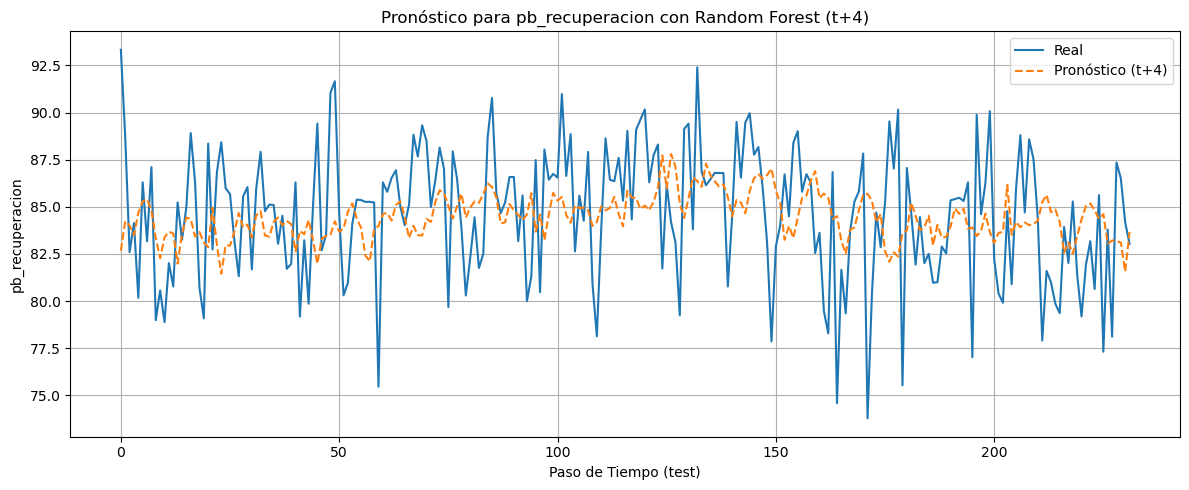

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

filename = 'data_variables_objetivo.csv'
columna = 'pb_recuperacion'
n_lags = 30
n_steps_ahead = 4

def compute_rsi(series, window=56):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_features(df_input, col_name):
    df_feat = df_input.copy()
    df_feat['sma_5'] = df_feat[col_name].rolling(window=5).mean()
    df_feat['momentum'] = df_feat[col_name] - df_feat[col_name].shift(4)
    df_feat['rsi'] = compute_rsi(df_feat[col_name], window=56)
    return df_feat

def create_lags(df_input, col_name, num_lags):
    df_feat = df_input.copy()
    for i in range(1, num_lags + 1):
        df_feat[f'lag_{i}'] = df_feat[col_name].shift(i)
    return df_feat

df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)

df_for_features = df_original[[columna]].copy()
df_for_features = create_lags(df_for_features, columna, n_lags)
df_for_features = add_features(df_for_features, columna)

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + ['sma_5', 'momentum', 'rsi']
X_candidate = df_for_features[feature_cols]
target_col_name = f'{columna}_target_t_plus_{n_steps_ahead}'
y_future_target = df_original[columna].shift(-n_steps_ahead).rename(target_col_name)

combined_df = X_candidate.join(y_future_target)
combined_df_cleaned = combined_df.dropna()

X_all = combined_df_cleaned[feature_cols]
y_all = combined_df_cleaned[target_col_name]
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=feature_cols)

initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")

if test_size <= 0:
    print("Error: No hay datos de prueba.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)):
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]

    model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions)
y_true_array = np.array(actuals)

if len(y_pred_array) == 0:
    print("No se generaron predicciones.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10)
    smape = np.mean(smape_terms) * 100

    print(f'\nPronóstico para t+{n_steps_ahead} con Random Forest y validación walk-forward:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead})', linestyle='--')
    plt.title(f'Pronóstico para {columna} con Random Forest (t+{n_steps_ahead})')
    plt.xlabel('Paso de Tiempo (test)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LightGBM

C:\Users\Cris2\AppData\Local\Temp\ipykernel_20284\199489418.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)


Iniciando walk-forward con LightGBM para t+14...
Train inicial: 534 / Test total: 229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 33
[LightGBM] [Info] Start training from score 86.548448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


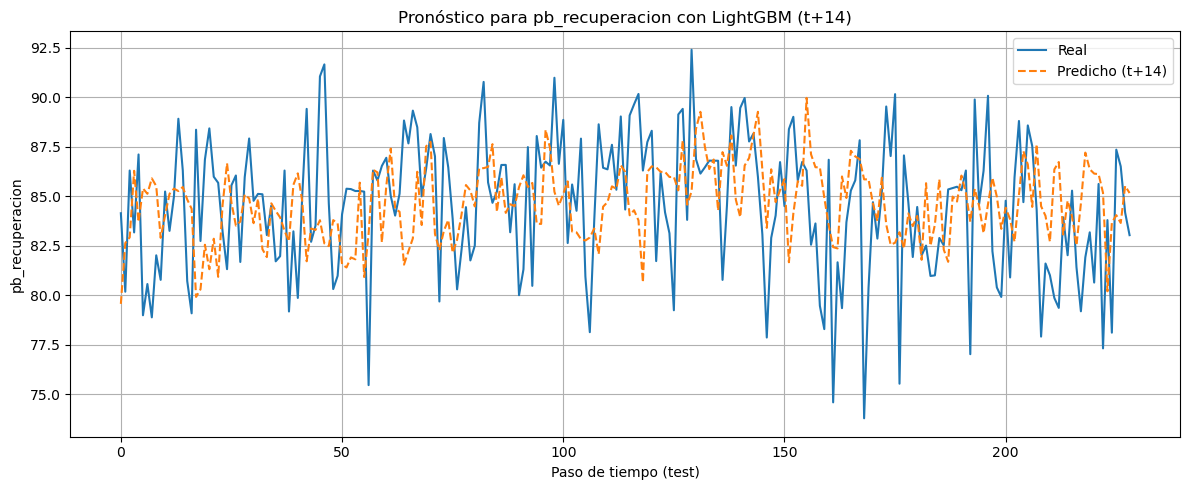

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor

filename = 'data_variables_objetivo.csv'
columna = 'pb_recuperacion'
n_lags = 30
n_steps_ahead = 14

def compute_rsi(series, window=56):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_features(df_input, col_name):
    df_feat = df_input.copy()
    df_feat['sma_5'] = df_feat[col_name].rolling(window=5).mean()
    df_feat['momentum'] = df_feat[col_name] - df_feat[col_name].shift(4)
    df_feat['rsi'] = compute_rsi(df_feat[col_name], window=56)
    return df_feat

def create_lags(df_input, col_name, num_lags):
    df_feat = df_input.copy()
    for i in range(1, num_lags + 1):
        df_feat[f'lag_{i}'] = df_feat[col_name].shift(i)
    return df_feat

# Leer datos
df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)

# Crear lags y features
df_for_features = df_original[[columna]].copy()
df_for_features = create_lags(df_for_features, columna, n_lags)
df_for_features = add_features(df_for_features, columna)

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + ['sma_5', 'momentum', 'rsi']
X_candidate = df_for_features[feature_cols]
target_col_name = f'{columna}_target_t_plus_{n_steps_ahead}'
y_future_target = df_original[columna].shift(-n_steps_ahead).rename(target_col_name)

# Unir features y target
combined_df = X_candidate.join(y_future_target)
combined_df_cleaned = combined_df.dropna()

# Separar X e y
X_all = combined_df_cleaned[feature_cols].reset_index(drop=True)
y_all = combined_df_cleaned[target_col_name].reset_index(drop=True)

# Escalar features
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=feature_cols)

# Walk-forward
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"Iniciando walk-forward con LightGBM para t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Train inicial: {initial_train_size} / Test total: {test_size}")

for i in range(initial_train_size, len(X_all_scaled)):
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]

    model = LGBMRegressor(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]
    predictions.append(y_pred)
    actuals.append(y_test)

# Evaluación
y_pred_array = np.array(predictions)
y_true_array = np.array(actuals)

mae = mean_absolute_error(y_true_array, y_pred_array)
rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
smape = np.mean(2 * np.abs(y_pred_array - y_true_array) / (np.abs(y_true_array) + np.abs(y_pred_array) + 1e-10)) * 100

print(f"\nResultados LightGBM t+{n_steps_ahead}:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"SMAPE: {smape:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_true_array, label='Real')
plt.plot(y_pred_array, label=f'Predicho (t+{n_steps_ahead})', linestyle='--')
plt.title(f'Pronóstico para {columna} con LightGBM (t+{n_steps_ahead})')
plt.xlabel('Paso de tiempo (test)')
plt.ylabel(columna)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Prueba con variables exogenas externas

Archivo 'data_variables_objetivo.csv' cargado. Columnas: ['horas_operacion', 'toneladas', 'au_cabeza', 'ag_cabeza', 'pb_cabeza']...

DataFrame base diario para ingeniería de features (shape: (421, 4)):
            pb_recuperacion  pb_concentrado_fe  pb_concentrado_zn  pb_colas_pb
date_index                                                                    
2024-01-02        86.145873           0.092581           0.096884     0.112637
2024-01-03        89.682565           0.106571           0.096208     0.116611
2024-01-04        88.261568           0.113569           0.101866     0.130284
2024-01-05        84.885887           0.125118           0.116679     0.180649
2024-01-06        89.632562           0.106511           0.092442     0.121448
Generando features para la serie objetivo principal: pb_recuperacion
Generando features para la serie exógena: pb_concentrado_fe
Generando features para la serie exógena: pb_concentrado_zn
Generando features para la serie exógena: pb_colas_pb
Ge

D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


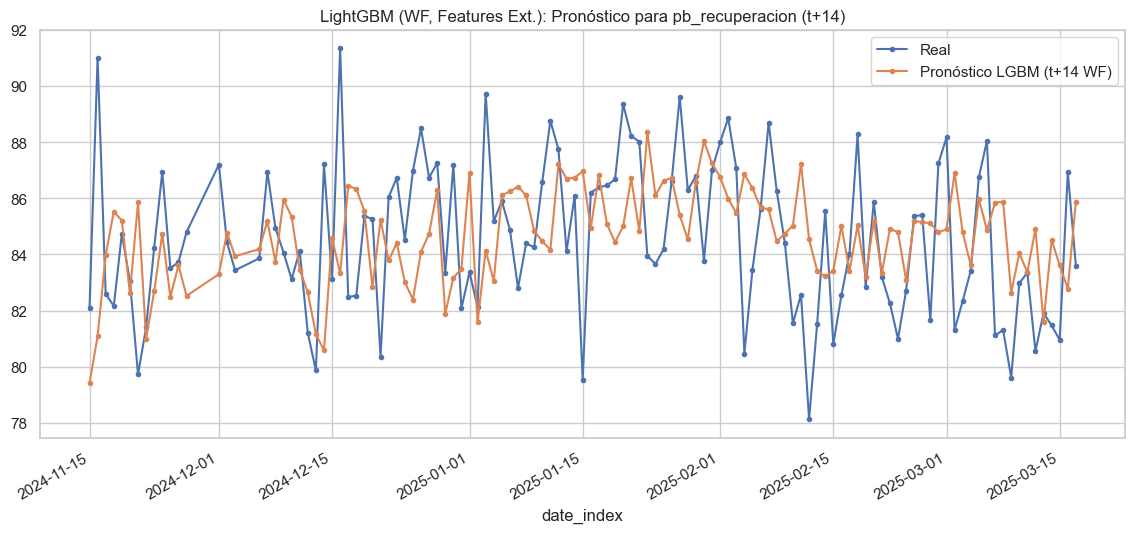

In [116]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor # Asumo que quieres seguir con LightGBM como en tu último fragmento

# --- Función para Cargar y Preparar Series Individuales (Agregación Diaria) ---
def cargar_y_agregar_serie_diaria(df_completo_con_turnos, nombre_columna):
    """
    Extrae una columna específica del DataFrame completo,
    la procesa para agregar por día (promediando turnos) y la devuelve como Serie.
    Asume que el índice de df_completo_con_turnos es 'fecha_turno' (ej. '2024-01-01_1').
    """
    if nombre_columna not in df_completo_con_turnos.columns:
        print(f"Error: La columna '{nombre_columna}' no se encontró en el DataFrame de entrada.")
        return None
        
    serie_con_turnos = df_completo_con_turnos[nombre_columna].copy()
    
    # Asegurar que el índice es string para el split
    serie_con_turnos.index = serie_con_turnos.index.astype(str)
    fecha_sin_turno = serie_con_turnos.index.str.split('_').str[0]
    
    serie_agrupada = serie_con_turnos.groupby(fecha_sin_turno).mean()
    serie_agrupada.index = pd.to_datetime(serie_agrupada.index)
    serie_agrupada = serie_agrupada.sort_index()
    return serie_agrupada

# --- Función de Generación de Características Modificada ---
def generar_features_completas(df_base_diario, 
                               columna_objetivo_principal, 
                               lista_columnas_exogenas,
                               num_lags_principal=14, 
                               num_lags_exogenas=7, # Menos lags para exógenas para controlar tamaño
                               ventanas_rolling_principal=[3, 7, 14],
                               ventanas_rolling_exogenas=[3, 7], # Menos ventanas para exógenas
                               periodo_estacional_principal=7):
    """
    Genera características para la serie objetivo principal y para una lista de series exógenas.
    Args:
        df_base_diario (pd.DataFrame): DataFrame con DatetimeIndex, conteniendo la columna objetivo
                                     principal y las columnas exógenas ya agregadas por día.
        columna_objetivo_principal (str): Nombre de la columna objetivo principal.
        lista_columnas_exogenas (list): Lista de nombres de las columnas exógenas.
    """
    if not isinstance(df_base_diario.index, pd.DatetimeIndex):
        raise ValueError("El DataFrame de entrada df_base_diario debe tener un DatetimeIndex.")

    df_resultado_features = df_base_diario.copy()

    # A. Features para la SERIE OBJETIVO PRINCIPAL
    print(f"Generando features para la serie objetivo principal: {columna_objetivo_principal}")
    serie_obj = df_base_diario[columna_objetivo_principal]
    for i in range(1, num_lags_principal + 1):
        df_resultado_features[f'{columna_objetivo_principal}_lag_{i}'] = serie_obj.shift(i)
    for ventana in ventanas_rolling_principal:
        df_resultado_features[f'{columna_objetivo_principal}_roll_mean_{ventana}'] = serie_obj.rolling(window=ventana, min_periods=1).mean().shift(1)
        df_resultado_features[f'{columna_objetivo_principal}_roll_std_{ventana}'] = serie_obj.rolling(window=ventana, min_periods=1).std().shift(1)
    df_resultado_features[f'{columna_objetivo_principal}_diff_1'] = serie_obj.diff(1)
    df_resultado_features[f'{columna_objetivo_original}_momentum_4'] = serie_obj - serie_obj.shift(4)
    if periodo_estacional_principal > 1:
         df_resultado_features[f'{columna_objetivo_principal}_diff_est_{periodo_estacional_principal}'] = serie_obj.diff(periods=periodo_estacional_principal)


    # B. Features para CADA SERIE EXÓGENA
    for col_exogena in lista_columnas_exogenas:
        print(f"Generando features para la serie exógena: {col_exogena}")
        serie_exog = df_base_diario[col_exogena]
        # Valor actual de la exógena (ya está en df_resultado_features)
        # Lags para la exógena
        for i in range(1, num_lags_exogenas + 1):
            df_resultado_features[f'{col_exogena}_lag_{i}'] = serie_exog.shift(i)
        # Rolling para la exógena
        for ventana in ventanas_rolling_exogenas:
            df_resultado_features[f'{col_exogena}_roll_mean_{ventana}'] = serie_exog.rolling(window=ventana, min_periods=1).mean().shift(1)
        # Diff para la exógena
        df_resultado_features[f'{col_exogena}_diff_1'] = serie_exog.diff(1)

    # C. Características de Calendario y Tendencia (se añaden una vez)
    df_resultado_features['dia_semana'] = df_resultado_features.index.dayofweek
    df_resultado_features['dia_mes'] = df_resultado_features.index.day
    df_resultado_features['dia_ano'] = df_resultado_features.index.dayofyear
    df_resultado_features['mes'] = df_resultado_features.index.month
    df_resultado_features['trimestre'] = df_resultado_features.index.quarter
    df_resultado_features['semana_iso'] = df_resultado_features.index.isocalendar().week.astype(int)
    df_resultado_features['ano'] = df_resultado_features.index.year
    
    df_dow_dummies = pd.get_dummies(df_resultado_features['dia_semana'], prefix='dia_sem', drop_first=False)
    df_resultado_features = pd.concat([df_resultado_features, df_dow_dummies], axis=1)

    if periodo_estacional_principal == 7:
        for k in range(1, (periodo_estacional_principal // 2) + 1):
            df_resultado_features[f'sin_semanal_{k}'] = np.sin(2 * np.pi * k * df_resultado_features['dia_semana'] / periodo_estacional_principal)
            df_resultado_features[f'cos_semanal_{k}'] = np.cos(2 * np.pi * k * df_resultado_features['dia_semana'] / periodo_estacional_principal)
    
    df_resultado_features['tendencia_idx'] = np.arange(len(df_resultado_features.index))
    
    print(f"Generación completa de características finalizada. Shape: {df_resultado_features.shape}")
    return df_resultado_features

# --- Función SMAPE ---
def smape_v2(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    epsilon = np.finfo(np.float64).eps 
    smape_values = 2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)
    return np.mean(smape_values) * 100

# --- INICIO DEL SCRIPT PRINCIPAL ---

# 1. Carga del DataFrame completo con todas las variables y turnos
filename = 'data_variables_objetivo.csv' # Tu archivo CSV completo
try:
    df_bruto_con_turnos = pd.read_csv(filename, index_col=0, parse_dates=False) # Asume que la primera col es 'fecha_turno'
    print(f"Archivo '{filename}' cargado. Columnas: {df_bruto_con_turnos.columns.tolist()[:5]}...")
except FileNotFoundError:
    print(f"ERROR: El archivo '{filename}' no fue encontrado.")
    exit()
except Exception as e:
    print(f"Error cargando el archivo '{filename}': {e}")
    exit()

# 2. Definición de la columna objetivo principal y las exógenas seleccionadas
columna_objetivo_principal = 'pb_recuperacion'
# Estas son las que identificaste como importantes (¡ASEGÚRATE QUE ESTÉN EN TU CSV!)
features_exogenas_nombres = ['pb_concentrado_fe', 'pb_concentrado_zn', 'pb_colas_pb'] 
# Puedes añadir más aquí si tu selección de correlación dio más, o ajustar el threshold.

# Verificar que todas las columnas necesarias existen
columnas_necesarias = [columna_objetivo_principal] + features_exogenas_nombres
for col in columnas_necesarias:
    if col not in df_bruto_con_turnos.columns:
        print(f"ERROR: La columna '{col}' no se encuentra en '{filename}'. Verifica los nombres.")
        exit()

# 3. Cargar y agregar por día CADA serie necesaria
serie_objetivo_diaria = cargar_y_agregar_serie_diaria(df_bruto_con_turnos, columna_objetivo_principal)
if serie_objetivo_diaria is None: exit()

df_base_diario_para_features = serie_objetivo_diaria.to_frame(name=columna_objetivo_principal)

for exog_name in features_exogenas_nombres:
    serie_exog_diaria = cargar_y_agregar_serie_diaria(df_bruto_con_turnos, exog_name)
    if serie_exog_diaria is not None:
        df_base_diario_para_features[exog_name] = serie_exog_diaria
    else:
        print(f"Advertencia: No se pudo procesar la serie exógena '{exog_name}'")

# Asegurar que no haya columnas duplicadas si alguna exógena tiene el mismo nombre que la objetivo
df_base_diario_para_features = df_base_diario_para_features.loc[:,~df_base_diario_para_features.columns.duplicated()]
print(f"\nDataFrame base diario para ingeniería de features (shape: {df_base_diario_para_features.shape}):")
print(df_base_diario_para_features.head())


# 4. Generar el conjunto completo de características
# Parámetros para la generación de features
num_lags_principal_config = 14 # Lags para pb_recuperacion
num_lags_exogenas_config = 7   # Lags para las 3 exógenas (menos para controlar tamaño)
ventanas_roll_principal_config = [3, 7, 14, 21]
ventanas_roll_exogenas_config = [3, 7]

df_con_todas_las_features = generar_features_completas(
    df_base_diario=df_base_diario_para_features,
    columna_objetivo_principal=columna_objetivo_principal,
    lista_columnas_exogenas=features_exogenas_nombres, # Pasar las exógenas originales
    num_lags_principal=num_lags_principal_config,
    num_lags_exogenas=num_lags_exogenas_config,
    ventanas_rolling_principal=ventanas_roll_principal_config,
    ventanas_rolling_exogenas=ventanas_roll_exogenas_config,
    periodo_estacional_principal=7
)

# 5. Crear la VERDADERA variable objetivo futura (para la columna objetivo principal)
n_steps_ahead = 14 # Horizonte de pronóstico
nombre_col_objetivo_futuro_final = f"objetivo_{columna_objetivo_principal}_t_mas_{n_steps_ahead}"
df_con_todas_las_features[nombre_col_objetivo_futuro_final] = df_con_todas_las_features[columna_objetivo_principal].shift(-n_steps_ahead)

# 6. Definir X e y finales para el modelo
# X no debe contener el objetivo original ni el objetivo futuro.
# Las columnas exógenas originales (ej. 'pb_concentrado_fe') SÍ se quedan en X,
# ya que sus lags y features derivadas son los predictores.
columnas_a_excluir_final_X = [columna_objetivo_principal, nombre_col_objetivo_futuro_final]

# Manejo de 'dia_semana' si se usan Fourier/Dummies (para modelos lineales principalmente)
if 'dia_semana' in df_con_todas_las_features.columns and \
   (any(col.startswith('dia_sem_') for col in df_con_todas_las_features.columns) or \
    any(col.startswith('sin_semanal_') for col in df_con_todas_las_features.columns)):
    if 'dia_semana' not in columnas_a_excluir_final_X:
        columnas_a_excluir_final_X.append('dia_semana')

X_pre_final = df_con_todas_las_features.drop(columns=columnas_a_excluir_final_X, errors='ignore')
y_pre_final = df_con_todas_las_features[nombre_col_objetivo_futuro_final]

df_final_para_entrenamiento = pd.concat([X_pre_final, y_pre_final], axis=1)
df_final_para_entrenamiento = df_final_para_entrenamiento.astype({col: int for col in df_final_para_entrenamiento.select_dtypes(include=['bool']).columns}, errors='ignore')
df_final_para_entrenamiento = df_final_para_entrenamiento.astype('float64', errors='ignore') 
df_final_para_entrenamiento = df_final_para_entrenamiento.dropna()

if df_final_para_entrenamiento.empty:
    print("ERROR: df_final_para_entrenamiento está vacío después de la preparación completa y dropna().")
    exit()

y_all = df_final_para_entrenamiento[nombre_col_objetivo_futuro_final]
X_all = df_final_para_entrenamiento.drop(columns=[nombre_col_objetivo_futuro_final])

print(f"\nForma de X_all (features finales) para el modelo: {X_all.shape}")
print(f"Forma de y_all (objetivo futuro t+{n_steps_ahead}) para el modelo: {y_all.shape}")
if nombre_col_objetivo_futuro_final in X_all.columns or columna_objetivo_principal in X_all.columns:
    print("¡¡¡ERROR DE FUGA DE DATOS DETECTADO EN X_all!!!")
    exit()
print("Verificación de fuga de datos en X_all OK.")

# 7. Escalado y Validación Walk-Forward (usando LightGBM como en tu último script)
X_all_original_index = X_all.index 
X_all_reset = X_all.reset_index(drop=True)
y_all_reset = y_all.reset_index(drop=True)

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_reset), columns=X_all.columns)

initial_train_size = int(len(X_all_scaled) * 0.7) 
predictions_model = []
actuals_model = []
test_indices_plot_model = []

print(f"\nIniciando validación walk-forward para LightGBM (pronóstico de t+{n_steps_ahead})...")
test_size = len(X_all_scaled) - initial_train_size
if test_size <= 0: print("Error: No hay datos de prueba."); exit()
print(f"Total datos: {len(X_all_scaled)}, Entrenamiento inicial: {initial_train_size}, Prueba: {test_size}")

for i in range(initial_train_size, len(X_all_scaled)): 
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all_reset.iloc[:i]
    X_test_current_step = X_all_scaled.iloc[i:i+1]
    y_actual_current_step = y_all_reset.iloc[i]

    model = XGBRegressor(n_estimators=300,learning_rate=0.1,max_depth=4,subsample=0.8,colsample_bytree=0.8,gamma=0.1,objective='reg:squarederror',random_state=42,n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_current_step)[0]
    
    predictions_model.append(y_pred)
    actuals_model.append(y_actual_current_step)
    test_indices_plot_model.append(X_all_original_index[i])

print("Validación walk-forward finalizada.")

y_pred_array_model = np.array(predictions_model) 
y_true_array_model = np.array(actuals_model)   

if len(y_pred_array_model) > 0:
    mae = mean_absolute_error(y_true_array_model, y_pred_array_model)
    rmse = mean_squared_error(y_true_array_model, y_pred_array_model, squared=False)
    mape = mean_absolute_percentage_error(y_true_array_model, y_pred_array_model)
    smape = smape_v2(y_true_array_model, y_pred_array_model)

    print(f'\nPronóstico para t+{n_steps_ahead} con LightGBM (Walk-Forward, Features Externas):')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape*100:.2f}%') 
    print(f'SMAPE: {smape:.2f}%')

    df_plot_model = pd.DataFrame({
        'Real': y_true_array_model,
        f'Pronóstico LGBM (t+{n_steps_ahead} WF)': y_pred_array_model
    }, index=pd.Index(test_indices_plot_model, name=X_all_original_index.name))
    
    df_plot_model.plot(figsize=(14, 6), marker='.')
    plt.title(f'LightGBM (WF, Features Ext.): Pronóstico para {columna_objetivo_principal} (t+{n_steps_ahead})')
    plt.show()
else:
    print("No se generaron predicciones.")

## Linear Regresion

C:\Users\Cris2\AppData\Local\Temp\ipykernel_20284\2430968778.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)


Forma de X_all después de la preparación: (763, 33)
Forma de y_all después de la preparación: (763,)

Iniciando validación walk-forward para pronóstico de t+14...
Tamaño total después de preparación: 763
Tamaño de entrenamiento inicial: 534
Tamaño de prueba (orígenes de pronóstico): 229
Validación walk-forward finalizada.

Pronóstico para t+14 con LinearRegression y validación walk-forward:
MAE: 2.8281
RMSE: 3.5912
MAPE: 0.0339
SMAPE: 3.36%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


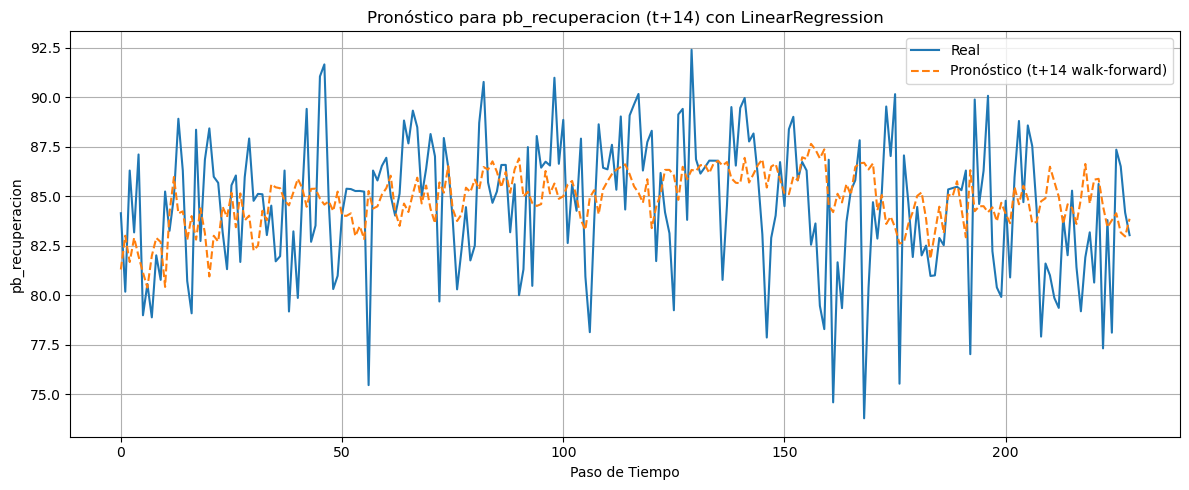

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

filename = 'data_variables_objetivo.csv'
columna = 'pb_recuperacion'
n_lags = 30
n_steps_ahead = 14

def add_features(df_input, col_name):
    df_feat = df_input.copy()
    df_feat['sma_5'] = df_feat[col_name].rolling(window=5).mean()
    df_feat['momentum'] = df_feat[col_name] - df_feat[col_name].shift(4)
    df_feat['rsi'] = compute_rsi(df_feat[col_name], window=56)
    return df_feat

def compute_rsi(series, window=56):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_lags(df_input, col_name, num_lags):
    df_feat = df_input.copy()
    for i in range(1, num_lags + 1):
        df_feat[f'lag_{i}'] = df_feat[col_name].shift(i)
    return df_feat

df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)
df_for_features = df_original[[columna]].copy()

df_for_features = create_lags(df_for_features, columna, n_lags)
df_for_features = add_features(df_for_features, columna)

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + ['sma_5', 'momentum', 'rsi']
X_candidate = df_for_features[feature_cols]

target_col_name = f'{columna}_target_t_plus_{n_steps_ahead}'
y_future_target = df_original[columna].shift(-n_steps_ahead).rename(target_col_name)
combined_df = X_candidate.join(y_future_target)
combined_df_cleaned = combined_df.dropna()

X_all = combined_df_cleaned[feature_cols]
y_all = combined_df_cleaned[target_col_name]

X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=feature_cols)

initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")

if test_size <= 0:
    print("Error: No hay datos de prueba.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)):
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions)
y_true_array = np.array(actuals)

if len(y_pred_array) == 0:
    print("No se generaron predicciones.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10)
    smape = np.mean(smape_terms) * 100

    print(f'\nPronóstico para t+{n_steps_ahead} con LinearRegression y validación walk-forward:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con LinearRegression')
    plt.xlabel('Paso de Tiempo')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\Cris2\AppData\Local\Temp\ipykernel_20284\2110310472.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)


Forma de X_all después de la preparación: (763, 33)
Forma de y_all después de la preparación: (763,)

Iniciando validación walk-forward para t+14...
Tamaño total: 763
Entrenamiento inicial: 534
Prueba: 229
Validación walk-forward finalizada.

Pronóstico t+14 con Ridge:
MAE: 2.8283
RMSE: 3.5806
MAPE: 0.0339
SMAPE: 3.36%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


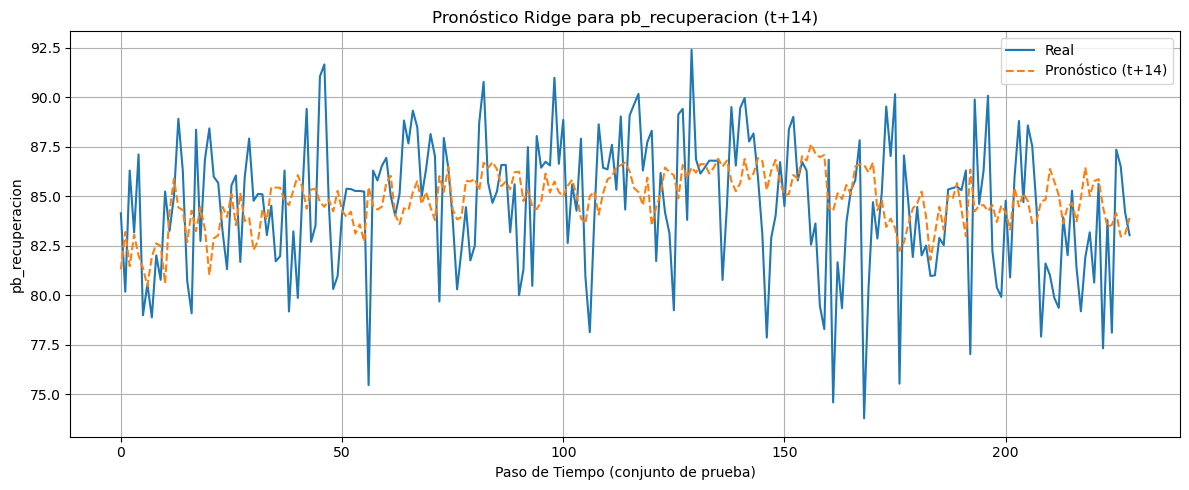

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

filename = 'data_variables_objetivo.csv'
columna = 'pb_recuperacion'
n_lags = 30
n_steps_ahead = 14

def add_features(df_input, col_name):
    df_feat = df_input.copy()
    df_feat['sma_5'] = df_feat[col_name].rolling(window=5).mean()
    df_feat['momentum'] = df_feat[col_name] - df_feat[col_name].shift(4)
    df_feat['rsi'] = compute_rsi(df_feat[col_name], window=56)
    return df_feat

def compute_rsi(series, window=56):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_lags(df_input, col_name, num_lags):
    df_feat = df_input.copy()
    for i in range(1, num_lags + 1):
        df_feat[f'lag_{i}'] = df_feat[col_name].shift(i)
    return df_feat

# Carga y procesamiento inicial
df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)
df_for_features = df_original[[columna]].copy()

df_for_features = create_lags(df_for_features, columna, n_lags)
df_for_features = add_features(df_for_features, columna)

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + ['sma_5', 'momentum', 'rsi']
X_candidate = df_for_features[feature_cols]
target_col_name = f'{columna}_target_t_plus_{n_steps_ahead}'
y_future_target = df_original[columna].shift(-n_steps_ahead).rename(target_col_name)

combined_df = X_candidate.join(y_future_target).dropna()

X_all = combined_df[feature_cols]
y_all = combined_df[target_col_name]
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación.")
    exit()

# Escalado
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=feature_cols)

# Validación walk-forward
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total: {len(X_all_scaled)}")
print(f"Entrenamiento inicial: {initial_train_size}")
print(f"Prueba: {test_size}")

if test_size <= 0:
    print("Error: No hay datos suficientes para prueba.")
    exit()

# Reemplazo de modelo XGBoost por Ridge
for i in range(initial_train_size, len(X_all_scaled)):
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]

    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions)
y_true_array = np.array(actuals)

if len(y_pred_array) == 0:
    print("No se generaron predicciones.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape = np.mean(2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10)) * 100

    print(f'\nPronóstico t+{n_steps_ahead} con Ridge:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead})', linestyle='--')
    plt.title(f'Pronóstico Ridge para {columna} (t+{n_steps_ahead})')
    plt.xlabel('Paso de Tiempo (conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Entrenando LSTM con 560 muestras...
Epoch 1/50


C:\Users\Cris2\AppData\Local\Temp\ipykernel_20284\3358318497.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename, index_col='date_index', parse_dates=True)
D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3686 - val_loss: 0.3637
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2989 - val_loss: 0.3653
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3065 - val_loss: 0.3678
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3054 - val_loss: 0.3556
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3012 - val_loss: 0.3518
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3135 - val_loss: 0.3584
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3024 - val_loss: 0.3648
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2863 - val_loss: 0.3888
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2980 - val_loss: 0.3658
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2891 - val_loss: 0.3643
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2788 - val_loss: 0.3653
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2815 - val_loss: 0.3646

D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


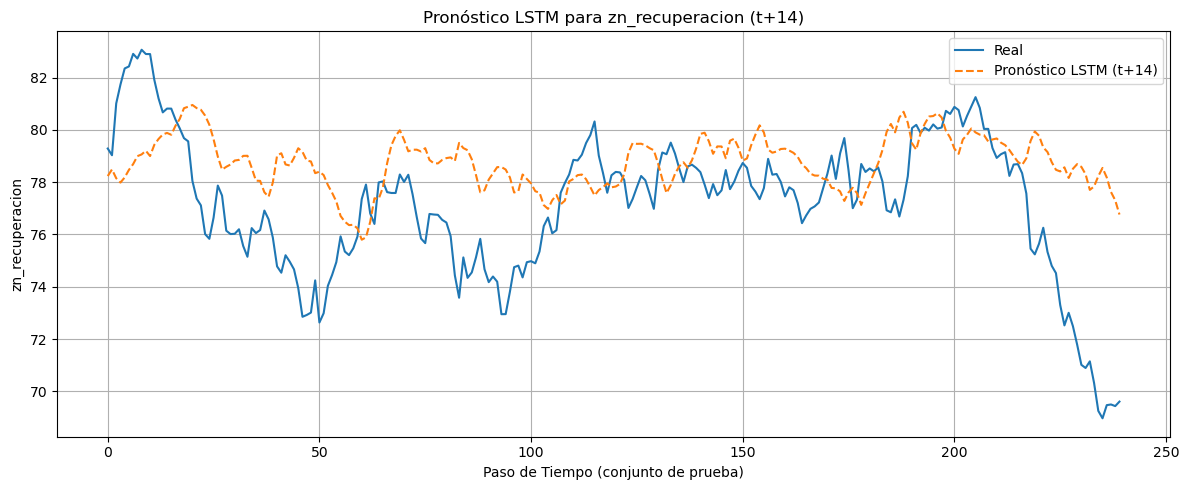

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

filename = 'data_variables_objetivo.csv'
columna = 'zn_recuperacion'
n_lags = 18
n_steps_ahead = 14

def create_lags_lstm(df, target_col, n_lags, n_steps_ahead):
    X, y = [], []
    for i in range(n_lags, len(df) - n_steps_ahead):
        X.append(df[i - n_lags:i])
        # Target es promedio de los siguientes n_steps_ahead para suavizar y facilitar predicción múltiple
        y.append(np.mean(df[i:i + n_steps_ahead]))
    return np.array(X), np.array(y)

# Carga y procesamiento
df = pd.read_csv(filename, index_col='date_index', parse_dates=True)
serie = df[columna].values.reshape(-1, 1)

# Escalado
scaler = StandardScaler()
serie_scaled = scaler.fit_transform(serie)

# Crear secuencias
X_all, y_all = create_lags_lstm(serie_scaled, target_col=0, n_lags=n_lags, n_steps_ahead=n_steps_ahead)

# Reshape X para LSTM (samples, timesteps, features)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

# División en entrenamiento y prueba
train_size = int(len(X_all) * 0.7)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

# Modelo LSTM con 2 capas y dropout
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_lags, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print(f"Entrenando LSTM con {X_train.shape[0]} muestras...")
history = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])

# Predecir
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_true, y_pred)
smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)) * 100

print(f'\nPronóstico t+{n_steps_ahead} con LSTM:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'SMAPE: {smape:.2f}%')

# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Real')
plt.plot(y_pred, label=f'Pronóstico LSTM (t+{n_steps_ahead})', linestyle='--')
plt.title(f'Pronóstico LSTM para {columna} (t+{n_steps_ahead})')
plt.xlabel('Paso de Tiempo (conjunto de prueba)')
plt.ylabel(columna)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\Cris2\AppData\Local\Temp\ipykernel_20284\678056458.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)


Forma de X_all después de la preparación: (763, 33)
Forma de y_all después de la preparación: (763,)

Iniciando validación walk-forward para pronóstico de t+14...
Tamaño total después de preparación: 763
Tamaño de entrenamiento inicial: 534
Tamaño de prueba (orígenes de pronóstico): 229
Validación walk-forward finalizada.

Pronóstico para t+14 con validación walk-forward y normalización:
MAE: 2.8772
RMSE: 3.6425
MAPE: 0.0344
SMAPE: 3.42%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


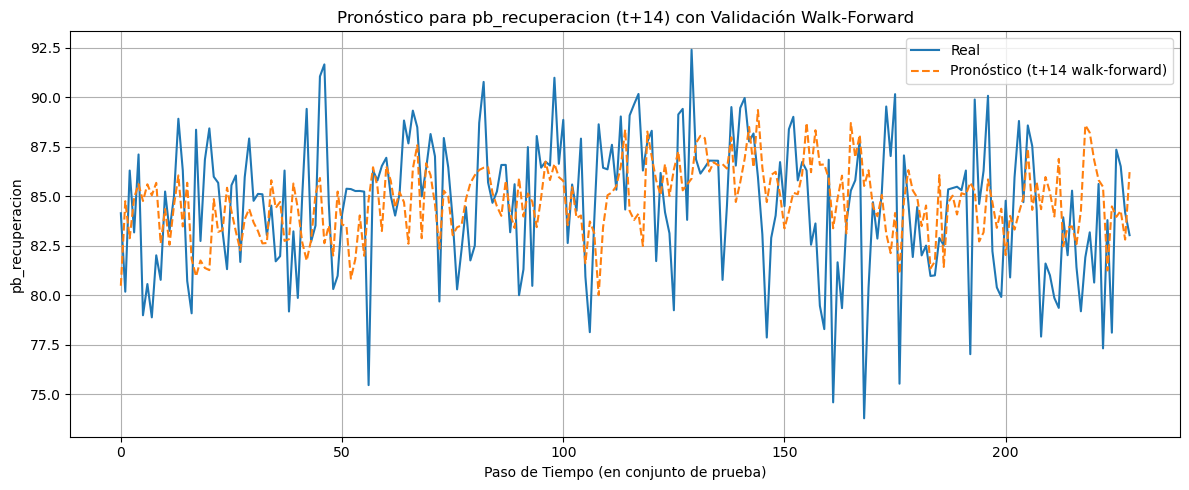

In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

filename = 'data_variables_objetivo.csv'
columna = 'pb_recuperacion' # Columna a pronosticar
n_lags = 30                  # Número de lags para usar como características
n_steps_ahead = 14          # Horizonte de pronóstico (t+10)

def add_features(df_input, col_name): # Renombrado df_input y col_name para claridad
    # Se crea una copia para evitar SettingWithCopyWarning si df_input es una vista
    df_feat = df_input.copy()
    df_feat['sma_5'] = df_feat[col_name].rolling(window=5).mean()
    df_feat['momentum'] = df_feat[col_name] - df_feat[col_name].shift(4)
    df_feat['rsi'] = compute_rsi(df_feat[col_name], window=56)
    return df_feat

def compute_rsi(series, window=56):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_lags(df_input, col_name, num_lags): # Renombrado df_input, col_name, num_lags
    df_feat = df_input.copy()
    for i in range(1, num_lags + 1):
        df_feat[f'lag_{i}'] = df_feat[col_name].shift(i)
    return df_feat

df_original = pd.read_csv(filename, index_col='date_index', parse_dates=True)

df_for_features = df_original[[columna]].copy()

# Añadir Lags
df_for_features = create_lags(df_for_features, columna, n_lags)

# Añadir Indicadores Técnicos
df_for_features = add_features(df_for_features, columna)

# Definir las columnas que serán nuestras características (features)
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + ['sma_5', 'momentum', 'rsi']

# Seleccionar solo las columnas de características para X
X_candidate = df_for_features[feature_cols]

# Crear la variable objetivo (y)
target_col_name = f'{columna}_target_t_plus_{n_steps_ahead}'
y_future_target = df_original[columna].shift(-n_steps_ahead).rename(target_col_name)

# Combinar características candidatas (X_candidate) y el objetivo futuro (y_future_target)
combined_df = X_candidate.join(y_future_target)

# Eliminar filas con cualquier valor NaN
combined_df_cleaned = combined_df.dropna()

# Separar X_all (características finales) e y_all (objetivo final)
X_all = combined_df_cleaned[feature_cols]
y_all = combined_df_cleaned[target_col_name]

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=feature_cols)

# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead

    model = XGBRegressor(n_estimators=300,learning_rate=0.1,max_depth=4,subsample=0.8,colsample_bytree=0.8,gamma=0.1,objective='reg:squarederror',random_state=42,n_jobs=-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
